# 🌋 GEOPHONE SEISMIC MONITORING & ROCKFALL PREDICTION SYSTEM

## Advanced Microseismic Analysis for Open Pit Mine Safety

### System Overview
This comprehensive analysis system processes geophone data to predict rockfall events in open pit mining operations through:

**Core Capabilities:**
- Real-time seismic event detection and classification
- Vibration magnitude analysis (mm/s and Richter scale)
- Temporal pattern recognition for precursor detection
- Machine learning-based rockfall prediction
- 3D visualization of seismic activity
- Alert system for critical vibration thresholds

**Analysis Components:**
1. Time series analysis of seismic events
2. Frequency domain analysis (FFT)
3. Event clustering and pattern detection
4. Magnitude-frequency distribution (Gutenberg-Richter)
5. Precursor identification algorithms
6. Predictive ML models (Random Forest, Gradient Boosting)
7. Risk assessment and early warning system

---

## 1. System Setup and Configuration

Import essential libraries for seismic analysis, machine learning, and visualization.

In [1]:
# Core Libraries
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import json

# Statistical Analysis
from scipy import stats, signal
from scipy.fft import fft, fftfreq
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error

# 3D Visualization
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# PDF Generation
from matplotlib.backends.backend_pdf import PdfPages

# Model Persistence
import joblib

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define base directory structure
BASE_DIR = r"c:\Users\rkste\Desktop\AI Rockfall Prediction"
DATA_DIR = os.path.join(BASE_DIR, "Data")
UPLOAD_DIR = os.path.join(BASE_DIR, "Upload")

# Geophone-specific directories
GEOPHONE_DIR = os.path.join(UPLOAD_DIR, "Geophone")
IMAGES_DIR = os.path.join(GEOPHONE_DIR, "images")
ANALYSIS_DIR = os.path.join(GEOPHONE_DIR, "Analysis")
REPORT_DIR = os.path.join(GEOPHONE_DIR, "Report")
THREED_DIR = os.path.join(GEOPHONE_DIR, "3-D")

# Create all necessary directories
for directory in [DATA_DIR, IMAGES_DIR, ANALYSIS_DIR, REPORT_DIR, THREED_DIR]:
    os.makedirs(directory, exist_ok=True)

# Define file paths
DATA_FILE = os.path.join(DATA_DIR, 'geophone_data.csv')

# Non-overwrite helper function
def get_next_filename(directory, base_name, extension):
    """
    Generate next available filename with sequential numbering to avoid overwriting.
    
    Args:
        directory: Target directory path
        base_name: Base filename without extension
        extension: File extension (e.g., '.csv', '.png', '.json')
    
    Returns:
        Full path to next available filename
    
    Example:
        get_next_filename('/path', 'data', '.csv')
        -> '/path/data.csv' (if doesn't exist)
        -> '/path/data_1.csv' (if data.csv exists)
        -> '/path/data_2.csv' (if data_1.csv exists)
    """
    base_path = os.path.join(directory, f"{base_name}{extension}")
    
    # If base file doesn't exist, use it
    if not os.path.exists(base_path):
        return base_path
    
    # Find all existing numbered versions
    pattern = os.path.join(directory, f"{base_name}_*{extension}")
    existing_files = glob.glob(pattern)
    
    # If no numbered versions exist, start with _1
    if not existing_files:
        return os.path.join(directory, f"{base_name}_1{extension}")
    
    # Extract numbers from existing files and find maximum
    max_num = 0
    for file_path in existing_files:
        filename = os.path.basename(file_path)
        # Match pattern: base_name_NUMBER.extension
        match = re.search(rf"{re.escape(base_name)}_(\d+){re.escape(extension)}$", filename)
        if match:
            num = int(match.group(1))
            max_num = max(max_num, num)
    
    # Return next number
    return os.path.join(directory, f"{base_name}_{max_num + 1}{extension}")

print("="*80)
print("GEOPHONE ROCKFALL PREDICTION ANALYSIS SYSTEM")
print("="*80)
print("\n✓ Libraries imported successfully")
print("✓ Directory structure created:")
print(f"  • Data: {DATA_DIR}")
print(f"  • Images: {IMAGES_DIR}")
print(f"  • 3-D: {THREED_DIR}")
print(f"  • Analysis: {ANALYSIS_DIR}")
print(f"  • Reports: {REPORT_DIR}")
print("\n✓ Non-overwrite system initialized")
print("✓ System ready for Geophone Seismic Analysis")
print("\nReady to analyze microseismic data for rockfall prediction!")
print("="*80)

GEOPHONE ROCKFALL PREDICTION ANALYSIS SYSTEM

✓ Libraries imported successfully
✓ Directory structure created:
  • Data: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data
  • Images: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\images
  • 3-D: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\3-D
  • Analysis: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\Analysis
  • Reports: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\Report

✓ Non-overwrite system initialized
✓ System ready for Geophone Seismic Analysis

Ready to analyze microseismic data for rockfall prediction!


## 2. Synthetic Seismic Data Generation

Generate realistic microseismic event data for open pit mine monitoring with multiple sensor locations.

In [2]:
def generate_geophone_data(n_records=200, days=180):
    """
    Generate synthetic geophone seismic data for rockfall prediction
    
    Parameters:
    -----------
    n_records : int, number of seismic events to generate
    days : int, time span in days
    
    Returns:
    --------
    DataFrame with seismic event data
    """
    np.random.seed(42)
    
    # Base timestamp
    start_date = datetime.now() - timedelta(days=days)
    
    # Generate timestamps (events distributed across time period)
    timestamps = [start_date + timedelta(
        days=np.random.uniform(0, days),
        hours=np.random.uniform(0, 24),
        minutes=np.random.uniform(0, 60)
    ) for _ in range(n_records)]
    timestamps.sort()
    
    data = []
    
    for i, ts in enumerate(timestamps):
        # Event detection time (same as timestamp for detected events)
        event_time = ts + timedelta(milliseconds=np.random.uniform(0, 100))
        
        # Generate event magnitude components
        # Vibration velocity (mm/s) - log-normal distribution
        vibration_velocity = np.random.lognormal(mean=0.5, sigma=1.2)
        
        # Convert to Richter scale equivalent (empirical relationship)
        # Richter = log10(A) + f(distance) - simplified for local events
        richter_scale = np.log10(vibration_velocity) + np.random.uniform(-0.5, 0.5)
        
        # Event classification based on magnitude
        if richter_scale < -1.0:
            event_type = 'Background Noise'
            risk_level = 'Low'
        elif richter_scale < 0.0:
            event_type = 'Microseismic'
            risk_level = 'Low'
        elif richter_scale < 1.0:
            event_type = 'Minor Event'
            risk_level = 'Medium'
        elif richter_scale < 2.0:
            event_type = 'Moderate Event'
            risk_level = 'High'
        else:
            event_type = 'Major Event'
            risk_level = 'Critical'
        
        # Spatial coordinates (mine pit locations)
        # 6 geophone stations positioned around the pit
        station_id = np.random.randint(1, 7)
        
        # Base station positions (in meters)
        station_positions = {
            1: (100, 200, -50),   # North rim
            2: (300, 180, -45),   # Northeast rim
            3: (350, 50, -40),    # East rim
            4: (280, -100, -48),  # Southeast rim
            5: (120, -120, -52),  # Southwest rim
            6: (50, 80, -55)      # West rim
        }
        
        base_x, base_y, base_z = station_positions[station_id]
        
        # Add variation to position (event epicenter estimation)
        x_coord = base_x + np.random.normal(0, 20)
        y_coord = base_y + np.random.normal(0, 20)
        z_coord = base_z + np.random.normal(0, 10)
        
        # Dominant frequency (Hz) - related to event type
        if event_type == 'Background Noise':
            frequency = np.random.uniform(50, 200)
        elif event_type == 'Microseismic':
            frequency = np.random.uniform(100, 500)
        else:
            frequency = np.random.uniform(5, 100)
        
        # Peak ground acceleration (g)
        pga = vibration_velocity * np.random.uniform(0.01, 0.05)
        
        # Event duration (seconds)
        duration = np.random.exponential(scale=2.0) + 0.1
        
        # Energy release (joules) - simplified calculation
        energy = 10 ** (1.5 * richter_scale + 4.8)
        
        # Sensor signal quality (0-1)
        signal_quality = np.random.beta(8, 2)
        
        # Temperature effect on readings
        temperature = np.random.normal(25, 5)
        temp_correction = 1 + (temperature - 25) * 0.001
        
        # Corrected magnitude
        corrected_magnitude = vibration_velocity * temp_correction
        
        data.append({
            'timestamp': ts,
            'event_time': event_time,
            'event_magnitude_mms': vibration_velocity,
            'richter_scale': richter_scale,
            'event_type': event_type,
            'risk_level': risk_level,
            'station_id': station_id,
            'x_coord': x_coord,
            'y_coord': y_coord,
            'z_coord': z_coord,
            'dominant_frequency_hz': frequency,
            'peak_ground_accel_g': pga,
            'event_duration_s': duration,
            'energy_joules': energy,
            'signal_quality': signal_quality,
            'temperature_c': temperature,
            'corrected_magnitude': corrected_magnitude
        })
    
    df = pd.DataFrame(data)
    
    # Save raw data
    df.to_csv(DATA_FILE, index=False)
    
    print(f"✓ Generated {len(df)} seismic events over {days} days")
    print(f"\nEvent Type Distribution:")
    print(df['event_type'].value_counts())
    print(f"\nRisk Level Distribution:")
    print(df['risk_level'].value_counts())
    print(f"\nMagnitude Statistics:")
    print(f"  Vibration Velocity: {df['event_magnitude_mms'].mean():.3f} ± {df['event_magnitude_mms'].std():.3f} mm/s")
    print(f"  Richter Scale: {df['richter_scale'].mean():.3f} ± {df['richter_scale'].std():.3f}")
    print(f"  Energy Release: {df['energy_joules'].mean():.2e} ± {df['energy_joules'].std():.2e} J")
    print(f"\n✓ Data saved to {DATA_FILE}")
    
    return df

# Generate data
df = generate_geophone_data(n_records=200, days=180)
df.head(10)

✓ Generated 200 seismic events over 180 days

Event Type Distribution:
event_type
Minor Event         102
Microseismic         69
Moderate Event       20
Background Noise      9
Name: count, dtype: int64

Risk Level Distribution:
risk_level
Medium    102
Low        78
High       20
Name: count, dtype: int64

Magnitude Statistics:
  Vibration Velocity: 3.201 ± 5.172 mm/s
  Richter Scale: 0.171 ± 0.621
  Energy Release: 7.00e+05 ± 1.62e+06 J

✓ Data saved to c:\Users\rkste\Desktop\AI Rockfall Prediction\Data\geophone_data.csv


,timestamp,event_time,event_magnitude_mms,richter_scale,event_type,risk_level,station_id,x_coord,y_coord,z_coord,dominant_frequency_hz,peak_ground_accel_g,event_duration_s,energy_joules,signal_quality,temperature_c,corrected_magnitude
0,2025-04-30 14:27:09.810170,2025-04-30 14:27:09.827064,0.619651,-0.619150,Microseismic,Low,1,88.819490,157.082865,-44.870587,457.686905,0.009388,0.901252,7.434889e+03,0.819223,18.869735,0.615852
1,2025-05-01 06:40:16.145491,2025-05-01 06:40:16.183220,1.733250,-0.258544,Microseismic,Low,4,292.283334,-84.849846,-53.305011,248.188841,0.050924,2.026004,2.583357e+04,0.561830,23.754820,1.731092
2,2025-05-02 06:29:43.431321,2025-05-02 06:29:43.456565,3.293228,0.529299,Minor Event,Medium,4,286.225003,-102.558352,-57.555404,55.598640,0.064873,0.727349,3.925988e+05,0.816832,21.133875,3.280496
3,2025-05-03 19:01:57.605561,2025-05-03 19:01:57.694614,1.082262,0.127925,Minor Event,Medium,4,306.861976,-126.153141,-22.266750,74.998135,0.034968,1.866367,9.814926e+04,0.942172,19.320673,1.076115
4,2025-05-04 07:46:26.403866,2025-05-04 07:46:26.464622,1.626657,0.041645,Minor Event,Medium,1,67.240119,192.771543,-52.384934,19.521618,0.032270,0.450330,7.285624e+04,0.887090,25.242608,1.627052
5,2025-05-05 17:18:24.722346,2025-05-05 17:18:24.763386,0.608268,0.266473,Minor Event,Medium,6,57.805065,78.301823,-52.626756,29.500769,0.010240,2.309119,1.583836e+05,0.587153,33.098061,0.613194
6,2025-05-05 20:57:36.461864,2025-05-05 20:57:36.538813,0.837387,-0.151637,Microseismic,Low,1,79.959066,204.317213,-32.910043,382.892038,0.034091,0.282675,3.737183e+04,0.855913,21.260150,0.834256
7,2025-05-06 07:45:57.696985,2025-05-06 07:45:57.751845,0.126621,-0.848574,Microseismic,Low,2,320.125856,168.462163,-36.643079,404.091144,0.004283,1.375713,3.366195e+03,0.661689,23.984773,0.126492
8,2025-05-06 17:19:36.674261,2025-05-06 17:19:36.770764,2.573778,0.848912,Minor Event,Medium,4,267.920296,-86.637981,-49.892077,73.551672,0.030689,3.142071,1.184043e+06,0.771400,22.131231,2.566395
9,2025-05-07 06:20:28.098801,2025-05-07 06:20:28.162177,0.728409,0.270241,Minor Event,Medium,1,94.595934,218.952339,-52.501226,40.809721,0.020765,0.817291,1.604582e+05,0.971679,25.080267,0.728467


## 3. Advanced Feature Engineering

Create sophisticated features for seismic pattern recognition and rockfall prediction.

In [3]:
def engineer_seismic_features(df):
    """
    Create advanced features for seismic analysis
    """
    df = df.copy()
    
    # Temporal features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    
    # Time between events (inter-event time)
    df['time_since_last_event'] = df['timestamp'].diff().dt.total_seconds()
    df['time_since_last_event'].fillna(df['time_since_last_event'].median(), inplace=True)
    
    # Rolling statistics (7-event window)
    window = 7
    df['rolling_mean_magnitude'] = df['event_magnitude_mms'].rolling(window=window, min_periods=1).mean()
    df['rolling_std_magnitude'] = df['event_magnitude_mms'].rolling(window=window, min_periods=1).std()
    df['rolling_max_magnitude'] = df['event_magnitude_mms'].rolling(window=window, min_periods=1).max()
    df['rolling_mean_richter'] = df['richter_scale'].rolling(window=window, min_periods=1).mean()
    
    # Cumulative features
    df['cumulative_events'] = np.arange(1, len(df) + 1)
    df['cumulative_energy'] = df['energy_joules'].cumsum()
    
    # Event rate (events per hour)
    df['event_rate_per_hour'] = 1 / (df['time_since_last_event'] / 3600)
    df['event_rate_per_hour'].replace([np.inf, -np.inf], 0, inplace=True)
    
    # Magnitude ratios and differences
    df['magnitude_change'] = df['event_magnitude_mms'].diff()
    df['magnitude_change'].fillna(0, inplace=True)
    df['richter_change'] = df['richter_scale'].diff()
    df['richter_change'].fillna(0, inplace=True)
    
    # Spatial features
    df['distance_from_center'] = np.sqrt(df['x_coord']**2 + df['y_coord']**2)
    df['depth'] = abs(df['z_coord'])
    
    # Distance from previous event
    df['spatial_shift'] = np.sqrt(
        df['x_coord'].diff()**2 + 
        df['y_coord'].diff()**2 + 
        df['z_coord'].diff()**2
    )
    df['spatial_shift'].fillna(0, inplace=True)
    
    # Frequency characteristics
    df['frequency_category'] = pd.cut(
        df['dominant_frequency_hz'],
        bins=[0, 50, 100, 200, 500],
        labels=['Very Low', 'Low', 'Medium', 'High']
    )
    
    # Energy metrics
    df['log_energy'] = np.log10(df['energy_joules'] + 1)
    df['energy_per_duration'] = df['energy_joules'] / df['event_duration_s']
    
    # Gutenberg-Richter b-value (local estimate)
    # b-value indicates stress state: lower b-value = higher stress
    df['local_b_value'] = df['richter_scale'].rolling(window=20, min_periods=5).apply(
        lambda x: -np.polyfit(x, np.log10(np.arange(len(x), 0, -1)), 1)[0] if len(x) > 1 else 1.0
    )
    df['local_b_value'].fillna(1.0, inplace=True)
    
    # Seismic moment (simplified)
    df['seismic_moment'] = 10 ** (1.5 * df['richter_scale'] + 9.1)
    
    # Risk score calculation
    df['risk_score'] = (
        df['event_magnitude_mms'] * 0.3 +
        df['richter_scale'] * 2.0 +
        (1 / df['time_since_last_event'].clip(lower=1)) * 10 +
        df['rolling_mean_magnitude'] * 0.2 +
        df['event_rate_per_hour'] * 0.1
    )
    
    # Encode categorical variables
    df['risk_level_encoded'] = df['risk_level'].map({
        'Low': 0,
        'Medium': 1,
        'High': 2,
        'Critical': 3
    })
    
    df['event_type_encoded'] = df['event_type'].map({
        'Background Noise': 0,
        'Microseismic': 1,
        'Minor Event': 2,
        'Moderate Event': 3,
        'Major Event': 4
    })
    
    # Save processed data to Analysis folder
    processed_file = get_next_filename(ANALYSIS_DIR, 'processed_geophone_data', '.csv')
    df.to_csv(processed_file, index=False)
    
    print(f"✓ Feature engineering complete")
    print(f"✓ Total features: {len(df.columns)}")
    print(f"\nKey Engineered Features:")
    print(f"  - Inter-event time: {df['time_since_last_event'].mean():.1f} ± {df['time_since_last_event'].std():.1f} seconds")
    print(f"  - Event rate: {df['event_rate_per_hour'].mean():.3f} events/hour")
    print(f"  - Cumulative energy: {df['cumulative_energy'].iloc[-1]:.2e} J")
    print(f"  - Average b-value: {df['local_b_value'].mean():.3f}")
    print(f"  - Risk score range: {df['risk_score'].min():.2f} - {df['risk_score'].max():.2f}")
    print(f"\n✓ Processed data saved to {processed_file}")
    
    return df

# Engineer features
df_processed = engineer_seismic_features(df)
print("\n" + "="*60)
print("PROCESSED DATA SAMPLE")
print("="*60)
df_processed[['timestamp', 'event_magnitude_mms', 'richter_scale', 'event_type', 
               'risk_level', 'risk_score', 'local_b_value', 'cumulative_energy']].head(10)

✓ Feature engineering complete
✓ Total features: 41

Key Engineered Features:
  - Inter-event time: 77637.6 ± 75699.7 seconds
  - Event rate: 0.177 events/hour
  - Cumulative energy: 1.40e+08 J
  - Average b-value: 0.041
  - Risk score range: -2.31 - 16.89

✓ Processed data saved to c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\Analysis\processed_geophone_data.csv

PROCESSED DATA SAMPLE


,timestamp,event_magnitude_mms,richter_scale,event_type,risk_level,risk_score,local_b_value,cumulative_energy
0,2025-04-30 14:27:09.810170,0.619651,-0.619150,Microseismic,Low,-0.921174,1.000000,7.434889e+03
1,2025-05-01 06:40:16.145491,1.733250,-0.258544,Microseismic,Low,0.244515,1.000000,3.326846e+04
2,2025-05-02 06:29:43.431321,3.293228,0.529299,Minor Event,Medium,2.427290,1.000000,4.258672e+05
3,2025-05-03 19:01:57.605561,1.082262,0.127925,Minor Event,Medium,0.919760,1.000000,5.240165e+05
4,2025-05-04 07:46:26.403866,1.626657,0.041645,Minor Event,Medium,0.913555,0.300538,5.968727e+05
5,2025-05-05 17:18:24.722346,0.608268,0.266473,Minor Event,Medium,1.017269,0.381342,7.552563e+05
6,2025-05-05 20:57:36.461864,0.837387,-0.151637,Microseismic,Low,0.256095,0.170473,7.926281e+05
7,2025-05-06 07:45:57.696985,0.126621,-0.848574,Microseismic,Low,-1.383717,-0.243800,7.959943e+05
8,2025-05-06 17:19:36.674261,2.573778,0.848912,Minor Event,Medium,2.770655,0.164885,1.980037e+06
9,2025-05-07 06:20:28.098801,0.728409,0.270241,Minor Event,Medium,0.983570,0.185899,2.140495e+06


## 4. Seismic Magnitude Analysis

Comprehensive analysis of event magnitudes and their temporal patterns.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\images\magnitude_analysis.png


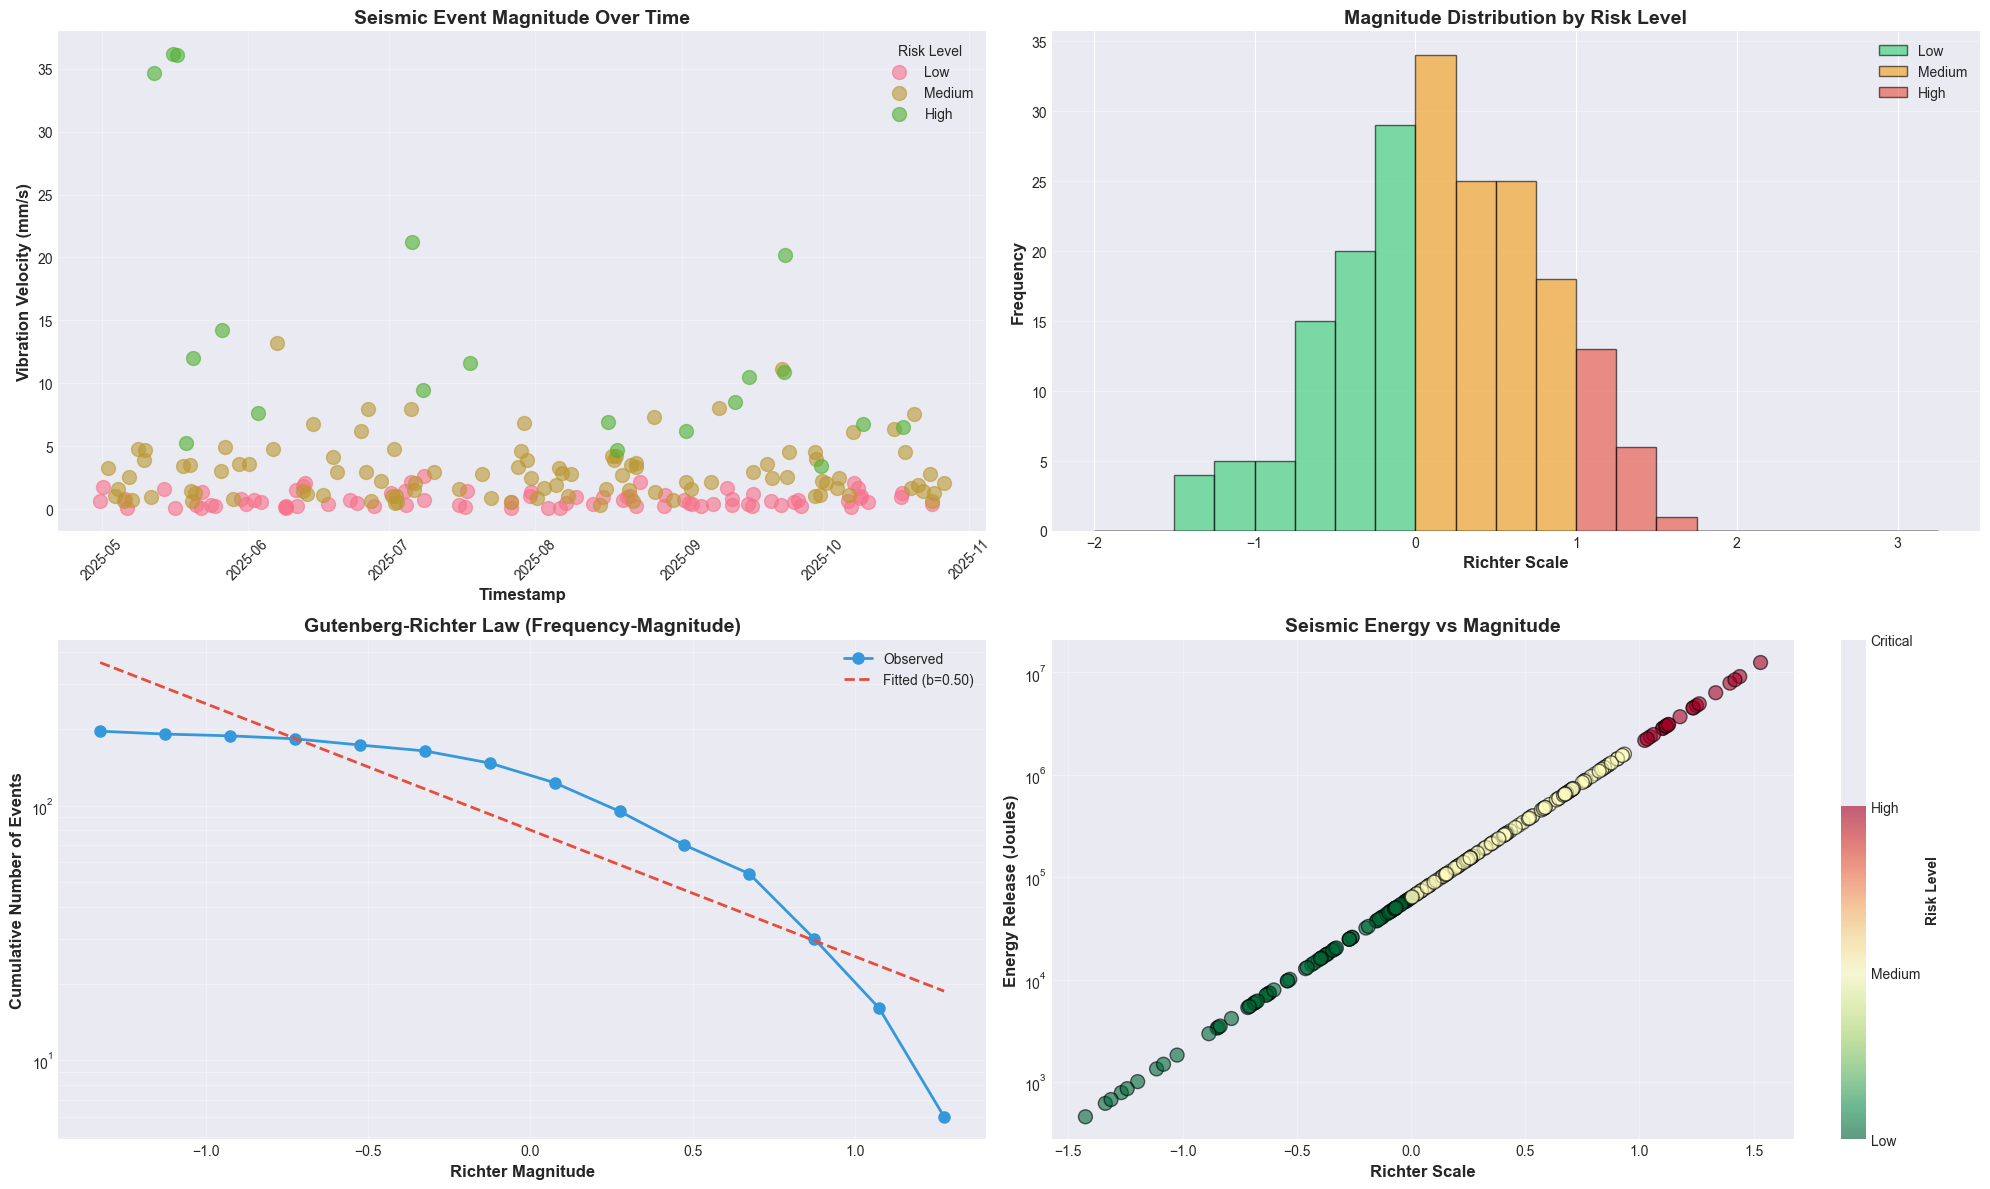

✓ Magnitude analysis visualizations generated

Key Statistics:
  Fitted b-value: 0.496
  Total seismic energy: 1.40e+08 J


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Magnitude Time Series with Risk Levels
ax1 = axes[0, 0]
for risk in df_processed['risk_level'].unique():
    subset = df_processed[df_processed['risk_level'] == risk]
    ax1.scatter(subset['timestamp'], subset['event_magnitude_mms'], 
                label=risk, alpha=0.6, s=100)

ax1.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
ax1.set_ylabel('Vibration Velocity (mm/s)', fontsize=12, fontweight='bold')
ax1.set_title('Seismic Event Magnitude Over Time', fontsize=14, fontweight='bold')
ax1.legend(title='Risk Level', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Richter Scale Distribution
ax2 = axes[0, 1]
richter_bins = np.arange(-2, 3.5, 0.25)
colors_risk = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c', 'Critical': '#8e44ad'}

for risk in ['Low', 'Medium', 'High', 'Critical']:
    if risk in df_processed['risk_level'].values:
        subset = df_processed[df_processed['risk_level'] == risk]
        ax2.hist(subset['richter_scale'], bins=richter_bins, alpha=0.6, 
                 label=risk, color=colors_risk[risk], edgecolor='black')

ax2.set_xlabel('Richter Scale', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Magnitude Distribution by Risk Level', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Gutenberg-Richter Relationship
ax3 = axes[1, 0]
magnitude_bins = np.arange(df_processed['richter_scale'].min(), 
                           df_processed['richter_scale'].max(), 0.2)
hist, bin_edges = np.histogram(df_processed['richter_scale'], bins=magnitude_bins)
cumulative = np.cumsum(hist[::-1])[::-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Filter positive values for log plot
valid_idx = cumulative > 0
ax3.semilogy(bin_centers[valid_idx], cumulative[valid_idx], 'o-', 
             color='#3498db', linewidth=2, markersize=8, label='Observed')

# Fit b-value
if len(bin_centers[valid_idx]) > 1:
    coeffs = np.polyfit(bin_centers[valid_idx], np.log10(cumulative[valid_idx]), 1)
    b_value = -coeffs[0]
    fitted = 10 ** (coeffs[0] * bin_centers[valid_idx] + coeffs[1])
    ax3.semilogy(bin_centers[valid_idx], fitted, '--', 
                 color='#e74c3c', linewidth=2, label=f'Fitted (b={b_value:.2f})')

ax3.set_xlabel('Richter Magnitude', fontsize=12, fontweight='bold')
ax3.set_ylabel('Cumulative Number of Events', fontsize=12, fontweight='bold')
ax3.set_title('Gutenberg-Richter Law (Frequency-Magnitude)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, which='both')

# Plot 4: Magnitude vs Energy Release
ax4 = axes[1, 1]
scatter = ax4.scatter(df_processed['richter_scale'], df_processed['energy_joules'],
                      c=df_processed['risk_level_encoded'], cmap='RdYlGn_r',
                      s=100, alpha=0.6, edgecolors='black')

ax4.set_xlabel('Richter Scale', fontsize=12, fontweight='bold')
ax4.set_ylabel('Energy Release (Joules)', fontsize=12, fontweight='bold')
ax4.set_title('Seismic Energy vs Magnitude', fontsize=14, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Risk Level', fontsize=10, fontweight='bold')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['Low', 'Medium', 'High', 'Critical'])

plt.tight_layout()

# Save figure
magnitude_analysis_file = get_next_filename(IMAGES_DIR, 'magnitude_analysis', '.png')
plt.savefig(magnitude_analysis_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {magnitude_analysis_file}")

plt.show()

print("✓ Magnitude analysis visualizations generated")
print(f"\nKey Statistics:")
print(f"  Fitted b-value: {b_value:.3f}")
print(f"  Total seismic energy: {df_processed['energy_joules'].sum():.2e} J")

## 5. Frequency Domain Analysis (FFT)

Analyze frequency characteristics of seismic events using Fast Fourier Transform.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\images\frequency_analysis_1.png


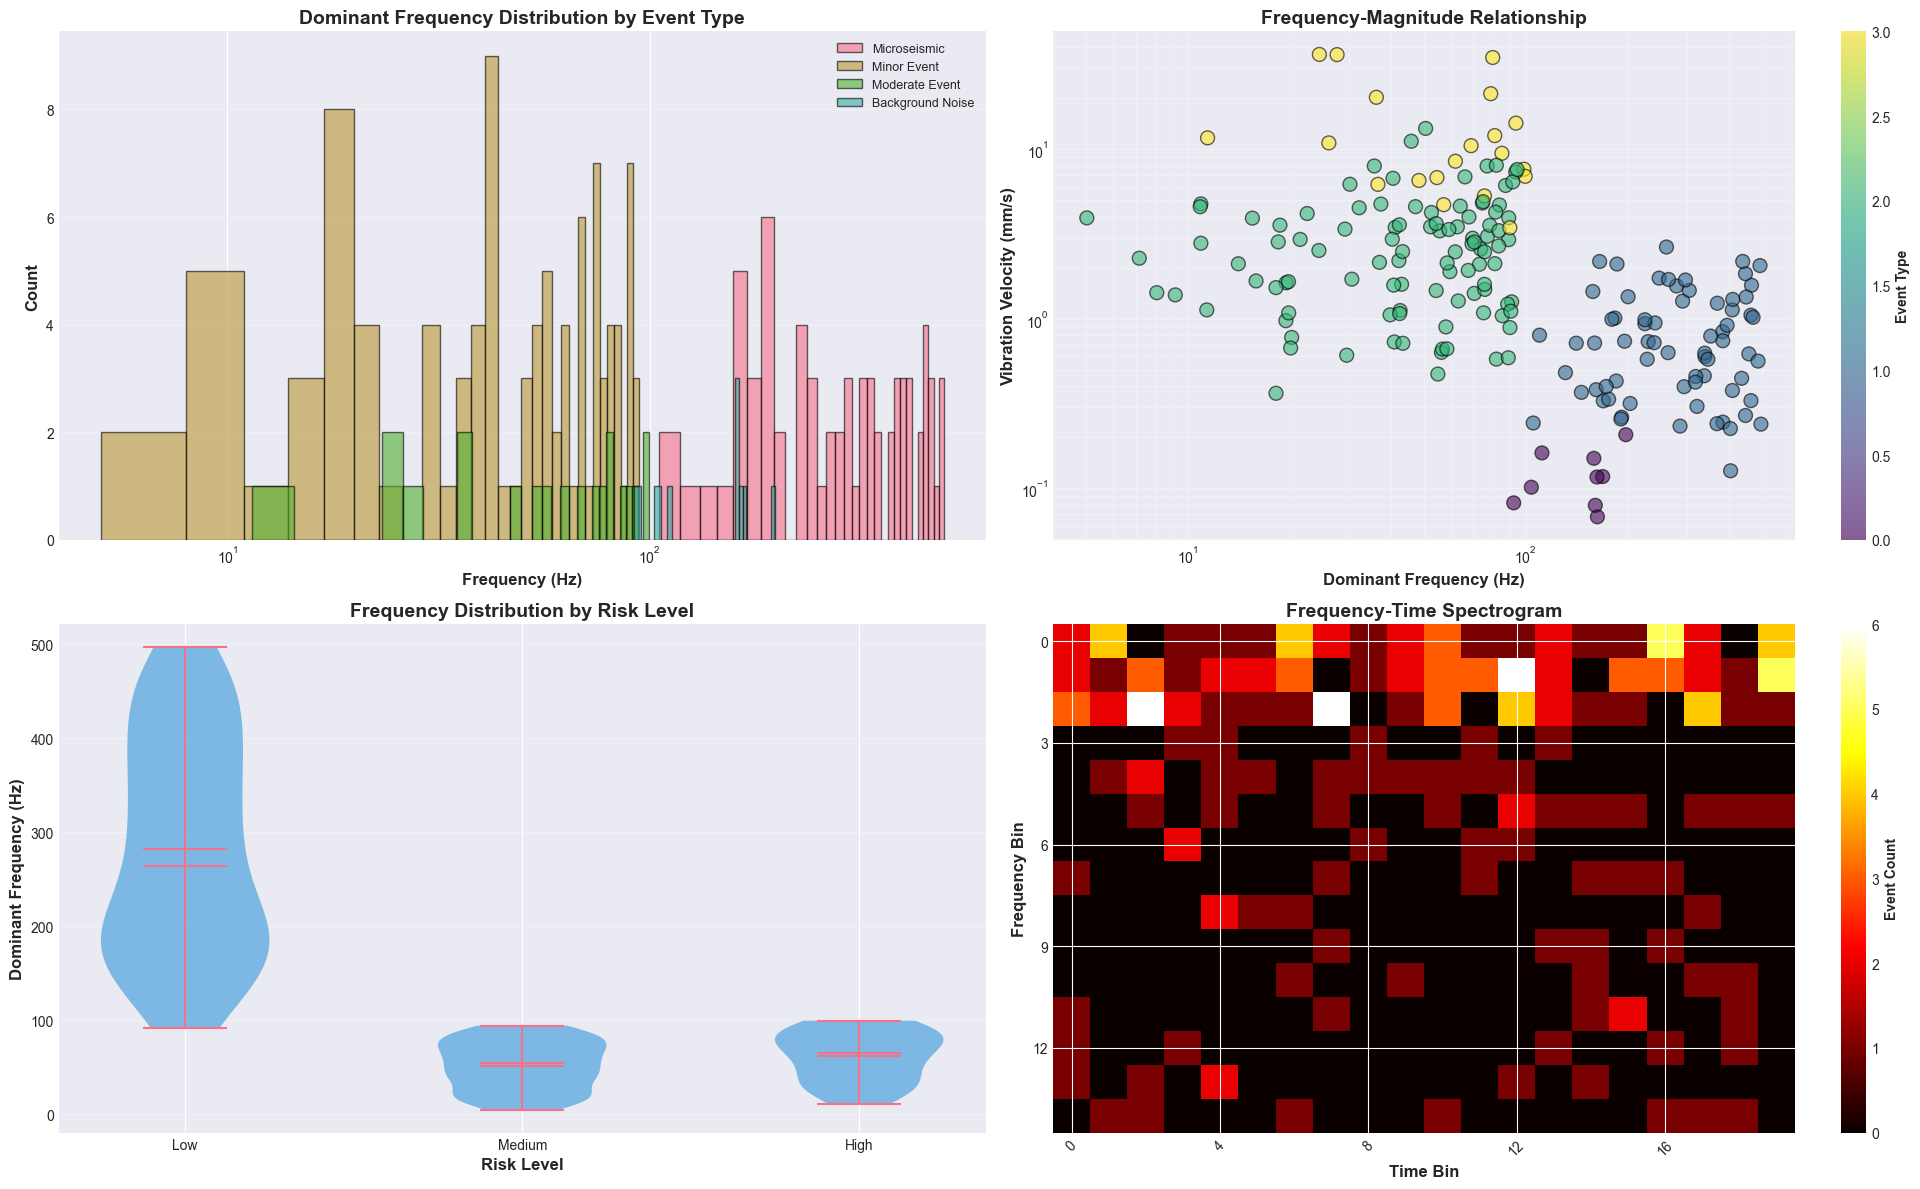

✓ Frequency domain analysis completed

Frequency Statistics:
  Mean frequency: 142.67 Hz
  Frequency range: 5.02 - 496.86 Hz


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Dominant Frequency Distribution
ax1 = axes[0, 0]
for event_type in df_processed['event_type'].unique():
    subset = df_processed[df_processed['event_type'] == event_type]
    ax1.hist(subset['dominant_frequency_hz'], bins=30, alpha=0.6, 
             label=event_type, edgecolor='black')

ax1.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Dominant Frequency Distribution by Event Type', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xscale('log')

# Plot 2: Frequency vs Magnitude
ax2 = axes[0, 1]
scatter = ax2.scatter(df_processed['dominant_frequency_hz'], 
                      df_processed['event_magnitude_mms'],
                      c=df_processed['event_type_encoded'], 
                      cmap='viridis', s=100, alpha=0.6, edgecolors='black')

ax2.set_xlabel('Dominant Frequency (Hz)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Vibration Velocity (mm/s)', fontsize=12, fontweight='bold')
ax2.set_title('Frequency-Magnitude Relationship', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, which='both')

cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Event Type', fontsize=10, fontweight='bold')

# Plot 3: Frequency by Risk Level (Violin Plot)
ax3 = axes[1, 0]
risk_order = ['Low', 'Medium', 'High', 'Critical']
data_for_violin = [df_processed[df_processed['risk_level'] == risk]['dominant_frequency_hz'].values 
                   for risk in risk_order if risk in df_processed['risk_level'].values]
positions = range(len(data_for_violin))

parts = ax3.violinplot(data_for_violin, positions=positions, showmeans=True, showmedians=True)

for pc in parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_alpha(0.6)

ax3.set_xlabel('Risk Level', fontsize=12, fontweight='bold')
ax3.set_ylabel('Dominant Frequency (Hz)', fontsize=12, fontweight='bold')
ax3.set_title('Frequency Distribution by Risk Level', fontsize=14, fontweight='bold')
ax3.set_xticks(positions)
ax3.set_xticklabels([risk for risk in risk_order if risk in df_processed['risk_level'].values])
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Frequency-Time Spectrogram (Simplified)
ax4 = axes[1, 1]

# Group data by time bins
df_processed['time_bin'] = pd.cut(df_processed['timestamp'], bins=20)
time_bin_centers = df_processed.groupby('time_bin')['timestamp'].mean()
freq_bins = pd.cut(df_processed['dominant_frequency_hz'], bins=15)

# Create heatmap data
heatmap_data = df_processed.groupby(['time_bin', freq_bins]).size().unstack(fill_value=0)

# Plot heatmap
im = ax4.imshow(heatmap_data.T, aspect='auto', cmap='hot', interpolation='nearest')
ax4.set_xlabel('Time Bin', fontsize=12, fontweight='bold')
ax4.set_ylabel('Frequency Bin', fontsize=12, fontweight='bold')
ax4.set_title('Frequency-Time Spectrogram', fontsize=14, fontweight='bold')

# Simplify labels
ax4.set_xticks(np.arange(0, len(heatmap_data), max(1, len(heatmap_data)//5)))
ax4.set_xticklabels([str(i) for i in range(0, len(heatmap_data), max(1, len(heatmap_data)//5))], rotation=45)
ax4.set_yticks(np.arange(0, len(heatmap_data.columns), max(1, len(heatmap_data.columns)//5)))
ax4.set_yticklabels([str(i) for i in range(0, len(heatmap_data.columns), max(1, len(heatmap_data.columns)//5))])

cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Event Count', fontsize=10, fontweight='bold')

plt.tight_layout()

# Save figure
frequency_analysis_file = get_next_filename(IMAGES_DIR, 'frequency_analysis', '.png')
plt.savefig(frequency_analysis_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {frequency_analysis_file}")

plt.show()

print("✓ Frequency domain analysis completed")
print(f"\nFrequency Statistics:")
print(f"  Mean frequency: {df_processed['dominant_frequency_hz'].mean():.2f} Hz")
print(f"  Frequency range: {df_processed['dominant_frequency_hz'].min():.2f} - {df_processed['dominant_frequency_hz'].max():.2f} Hz")

## 6. 3D Spatial Event Analysis

Visualize seismic event locations in 3D space across the mine pit.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\3-D\spatial_3d_analysis.png


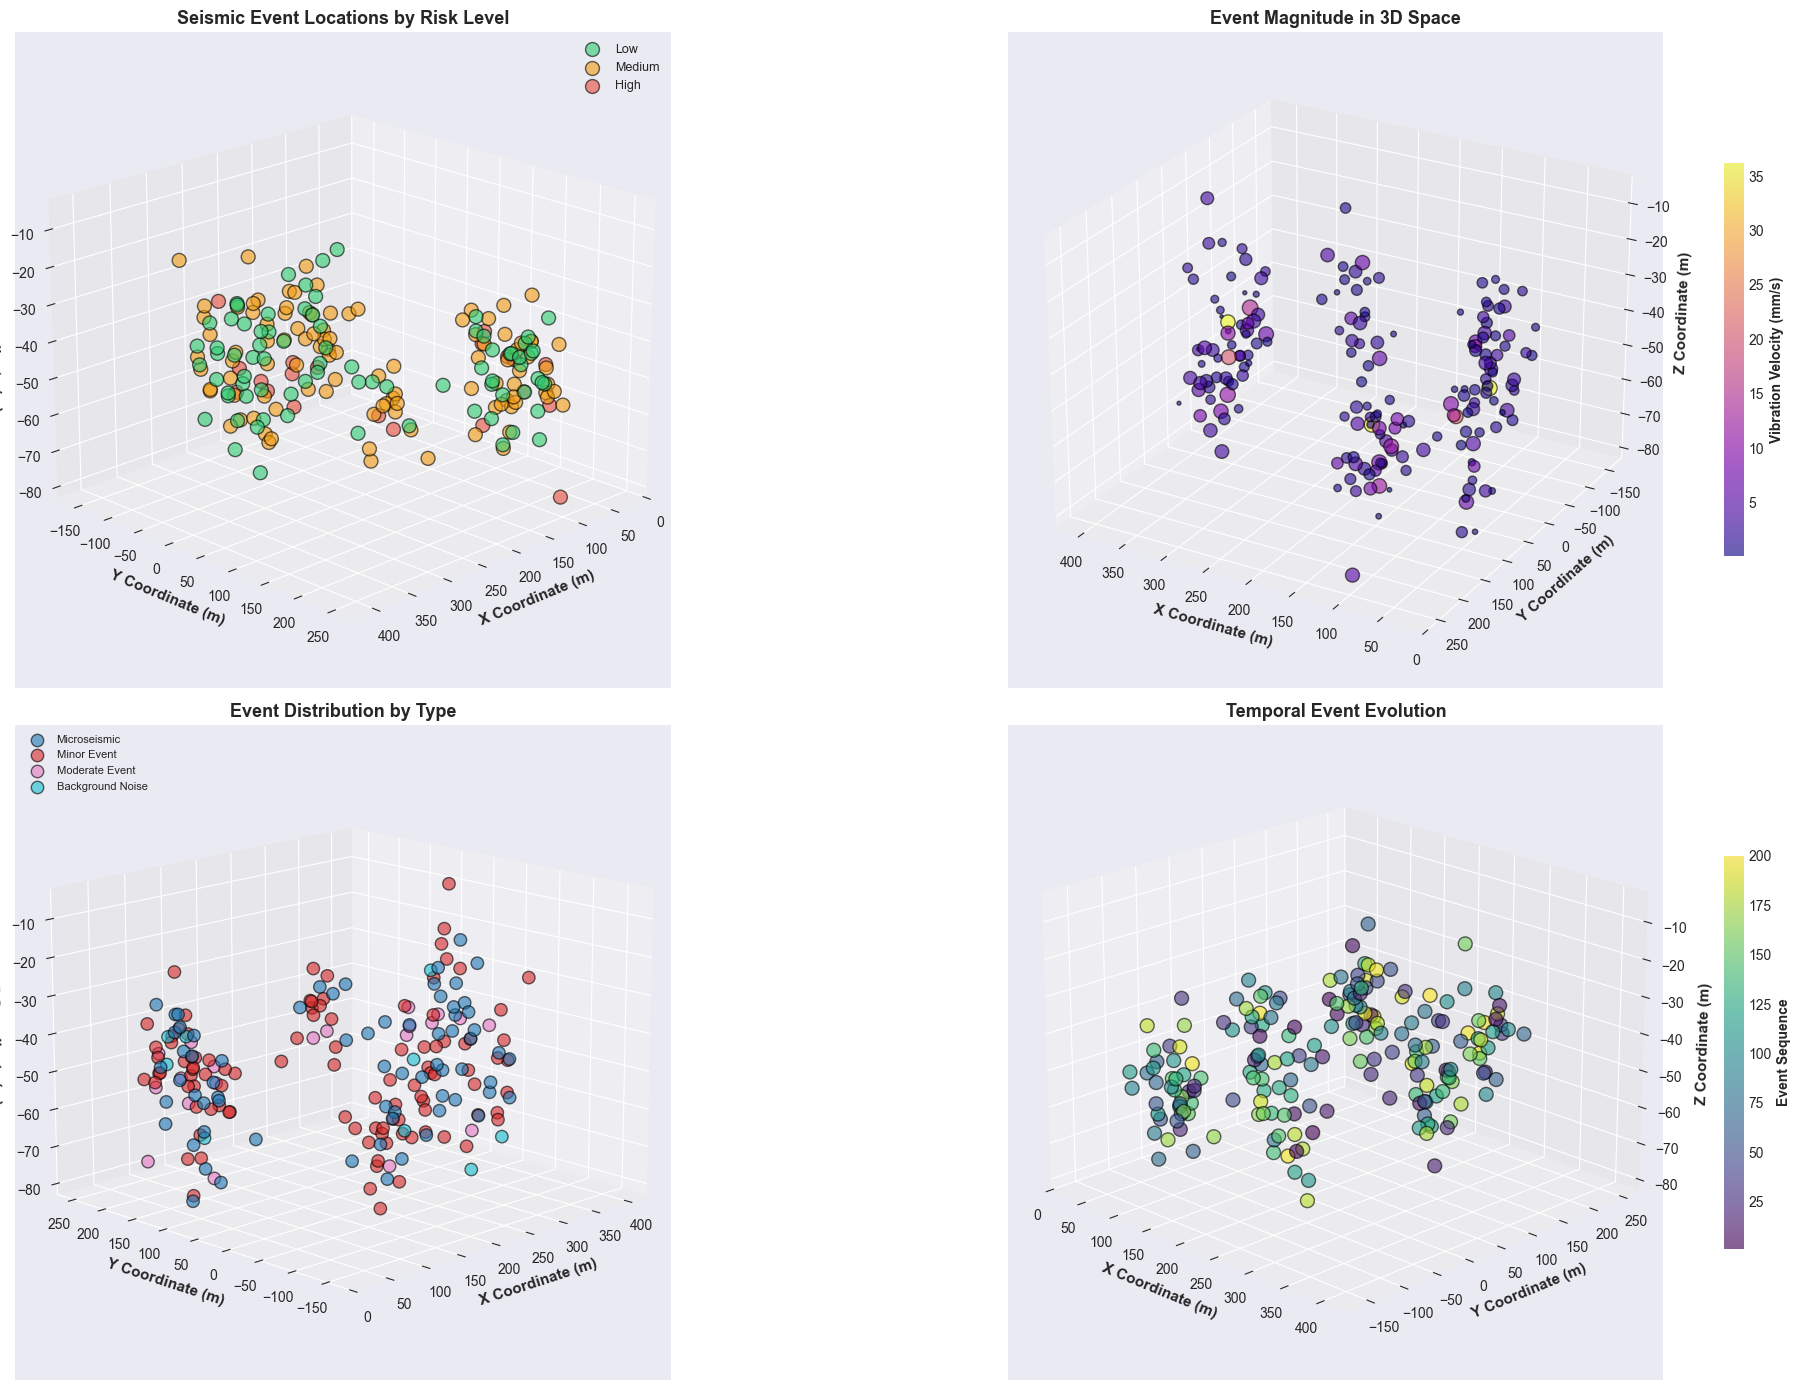

✓ 3D spatial analysis visualizations generated

Spatial Statistics:
  X range: 27.2 to 403.9 m
  Y range: -156.6 to 248.2 m
  Depth range: 7.4 to 77.8 m


In [7]:
fig = plt.figure(figsize=(22, 14))

# Plot 1: 3D Event Locations colored by Risk
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

risk_colors = {
    'Low': '#2ecc71',
    'Medium': '#f39c12',
    'High': '#e74c3c',
    'Critical': '#8e44ad'
}

for risk in ['Low', 'Medium', 'High', 'Critical']:
    if risk in df_processed['risk_level'].values:
        subset = df_processed[df_processed['risk_level'] == risk]
        ax1.scatter(subset['x_coord'], subset['y_coord'], subset['z_coord'],
                   c=risk_colors[risk], label=risk, s=100, alpha=0.6, edgecolors='black')

ax1.set_xlabel('X Coordinate (m)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Y Coordinate (m)', fontsize=11, fontweight='bold')
ax1.set_zlabel('Z Coordinate (m)', fontsize=11, fontweight='bold')
ax1.set_title('Seismic Event Locations by Risk Level', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.view_init(elev=20, azim=45)

# Plot 2: 3D Events colored by Magnitude
ax2 = fig.add_subplot(2, 2, 2, projection='3d')

scatter = ax2.scatter(df_processed['x_coord'], df_processed['y_coord'], df_processed['z_coord'],
                     c=df_processed['event_magnitude_mms'], cmap='plasma',
                     s=df_processed['richter_scale']*50 + 50, alpha=0.6, edgecolors='black')

ax2.set_xlabel('X Coordinate (m)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Y Coordinate (m)', fontsize=11, fontweight='bold')
ax2.set_zlabel('Z Coordinate (m)', fontsize=11, fontweight='bold')
ax2.set_title('Event Magnitude in 3D Space', fontsize=13, fontweight='bold')
ax2.view_init(elev=25, azim=120)

cbar = fig.colorbar(scatter, ax=ax2, shrink=0.6)
cbar.set_label('Vibration Velocity (mm/s)', fontsize=10, fontweight='bold')

# Plot 3: 3D Events by Event Type
ax3 = fig.add_subplot(2, 2, 3, projection='3d')

event_colors = plt.cm.tab10(np.linspace(0, 1, len(df_processed['event_type'].unique())))

for idx, event_type in enumerate(df_processed['event_type'].unique()):
    subset = df_processed[df_processed['event_type'] == event_type]
    ax3.scatter(subset['x_coord'], subset['y_coord'], subset['z_coord'],
               c=[event_colors[idx]], label=event_type, s=80, alpha=0.6, edgecolors='black')

ax3.set_xlabel('X Coordinate (m)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Y Coordinate (m)', fontsize=11, fontweight='bold')
ax3.set_zlabel('Z Coordinate (m)', fontsize=11, fontweight='bold')
ax3.set_title('Event Distribution by Type', fontsize=13, fontweight='bold')
ax3.legend(fontsize=8, loc='upper left')
ax3.view_init(elev=15, azim=225)

# Plot 4: Temporal Evolution in 3D (with time as color)
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

# Use cumulative events as time proxy
scatter = ax4.scatter(df_processed['x_coord'], df_processed['y_coord'], df_processed['z_coord'],
                     c=df_processed['cumulative_events'], cmap='viridis',
                     s=100, alpha=0.6, edgecolors='black')

ax4.set_xlabel('X Coordinate (m)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Y Coordinate (m)', fontsize=11, fontweight='bold')
ax4.set_zlabel('Z Coordinate (m)', fontsize=11, fontweight='bold')
ax4.set_title('Temporal Event Evolution', fontsize=13, fontweight='bold')
ax4.view_init(elev=20, azim=315)

cbar = fig.colorbar(scatter, ax=ax4, shrink=0.6)
cbar.set_label('Event Sequence', fontsize=10, fontweight='bold')

plt.tight_layout()

# Save figure to 3-D folder (it's a 3D visualization)
spatial_3d_file = get_next_filename(THREED_DIR, 'spatial_3d_analysis', '.png')
plt.savefig(spatial_3d_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {spatial_3d_file}")

plt.show()

print("✓ 3D spatial analysis visualizations generated")
print(f"\nSpatial Statistics:")
print(f"  X range: {df_processed['x_coord'].min():.1f} to {df_processed['x_coord'].max():.1f} m")
print(f"  Y range: {df_processed['y_coord'].min():.1f} to {df_processed['y_coord'].max():.1f} m")
print(f"  Depth range: {df_processed['depth'].min():.1f} to {df_processed['depth'].max():.1f} m")

## 7. Event Clustering Analysis

Apply DBSCAN and K-Means clustering to identify seismic activity zones.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\3-D\clustering_analysis.png


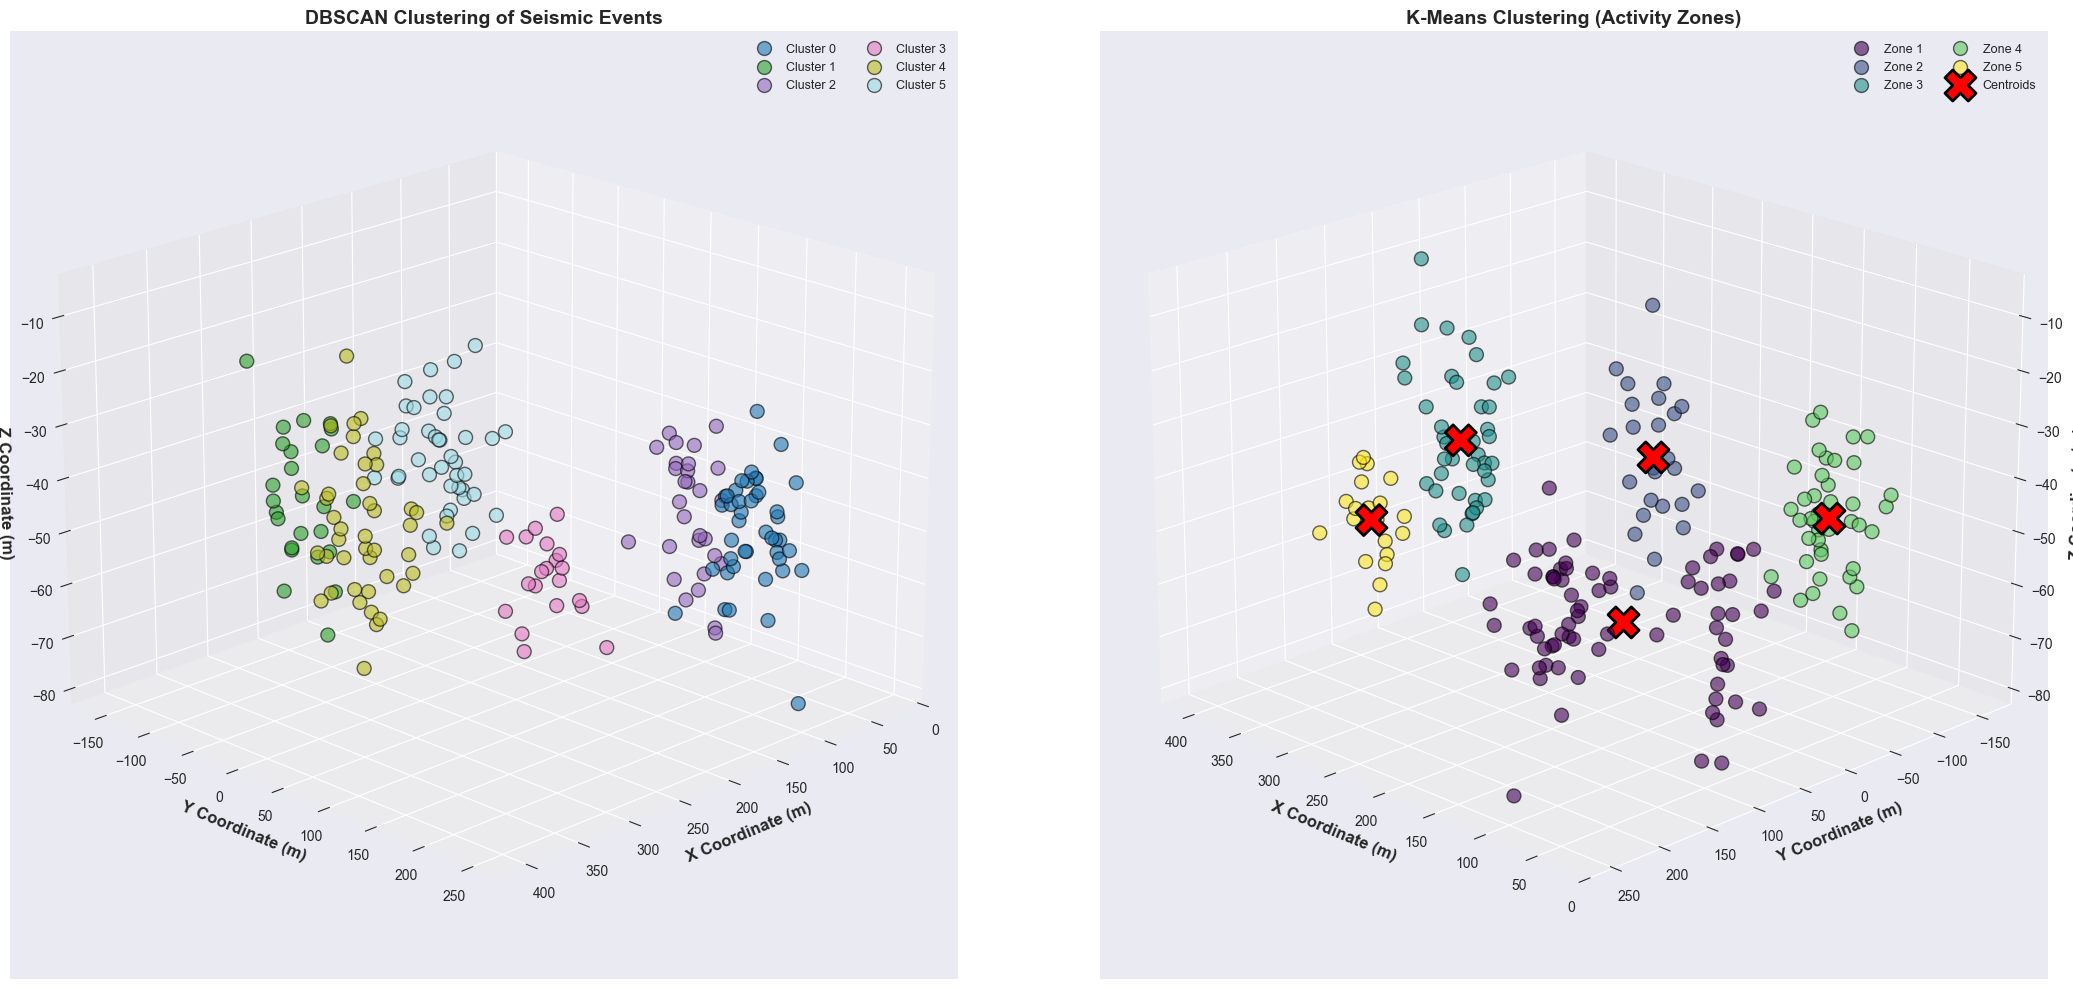

✓ Clustering analysis completed

DBSCAN Results:
  Number of clusters: 6
  Noise points: 0

K-Means Results:
  Zone 1: 72 events
  Zone 2: 25 events
  Zone 3: 42 events
  Zone 4: 41 events
  Zone 5: 20 events

Zone Risk Analysis:
  Zone 1: 9/72 high-risk events (12.5%)
  Zone 2: 2/25 high-risk events (8.0%)
  Zone 3: 6/42 high-risk events (14.3%)
  Zone 4: 1/41 high-risk events (2.4%)
  Zone 5: 2/20 high-risk events (10.0%)


In [8]:
# Perform clustering analysis
spatial_features = df_processed[['x_coord', 'y_coord', 'z_coord']].values

# DBSCAN Clustering
dbscan = DBSCAN(eps=50, min_samples=5)
df_processed['dbscan_cluster'] = dbscan.fit_predict(spatial_features)

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df_processed['kmeans_cluster'] = kmeans.fit_predict(spatial_features)

# Visualizations
fig = plt.figure(figsize=(22, 10))

# Plot 1: DBSCAN Clustering
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

unique_clusters = np.unique(df_processed['dbscan_cluster'])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for idx, cluster in enumerate(unique_clusters):
    subset = df_processed[df_processed['dbscan_cluster'] == cluster]
    label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    ax1.scatter(subset['x_coord'], subset['y_coord'], subset['z_coord'],
               c=[colors[idx]], label=label, s=100, alpha=0.6, edgecolors='black')

ax1.set_xlabel('X Coordinate (m)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Y Coordinate (m)', fontsize=12, fontweight='bold')
ax1.set_zlabel('Z Coordinate (m)', fontsize=12, fontweight='bold')
ax1.set_title('DBSCAN Clustering of Seismic Events', fontsize=14, fontweight='bold')
ax1.legend(fontsize=9, ncol=2)
ax1.view_init(elev=20, azim=45)

# Plot 2: K-Means Clustering
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

colors_kmeans = plt.cm.viridis(np.linspace(0, 1, 5))

for cluster in range(5):
    subset = df_processed[df_processed['kmeans_cluster'] == cluster]
    ax2.scatter(subset['x_coord'], subset['y_coord'], subset['z_coord'],
               c=[colors_kmeans[cluster]], label=f'Zone {cluster+1}', 
               s=100, alpha=0.6, edgecolors='black')

# Plot centroids
centroids = kmeans.cluster_centers_
ax2.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='red', marker='X', s=500, edgecolors='black', linewidths=2,
           label='Centroids', alpha=1.0)

ax2.set_xlabel('X Coordinate (m)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Y Coordinate (m)', fontsize=12, fontweight='bold')
ax2.set_zlabel('Z Coordinate (m)', fontsize=12, fontweight='bold')
ax2.set_title('K-Means Clustering (Activity Zones)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9, ncol=2)
ax2.view_init(elev=20, azim=135)

plt.tight_layout()

# Save figure to 3-D folder (it's a 3D visualization)
clustering_file = get_next_filename(THREED_DIR, 'clustering_analysis', '.png')
plt.savefig(clustering_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {clustering_file}")

plt.show()

# Print clustering statistics
print("✓ Clustering analysis completed")
print(f"\nDBSCAN Results:")
print(f"  Number of clusters: {len(unique_clusters[unique_clusters != -1])}")
print(f"  Noise points: {sum(df_processed['dbscan_cluster'] == -1)}")
print(f"\nK-Means Results:")
for cluster in range(5):
    count = sum(df_processed['kmeans_cluster'] == cluster)
    print(f"  Zone {cluster+1}: {count} events")
    
# Zone risk analysis
print(f"\nZone Risk Analysis:")
for cluster in range(5):
    zone_data = df_processed[df_processed['kmeans_cluster'] == cluster]
    high_risk = sum(zone_data['risk_level'].isin(['High', 'Critical']))
    total = len(zone_data)
    pct = (high_risk / total * 100) if total > 0 else 0
    print(f"  Zone {cluster+1}: {high_risk}/{total} high-risk events ({pct:.1f}%)")

## 8. Correlation and Statistical Analysis

Examine relationships between seismic parameters and identify key patterns.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\images\correlation_analysis.png


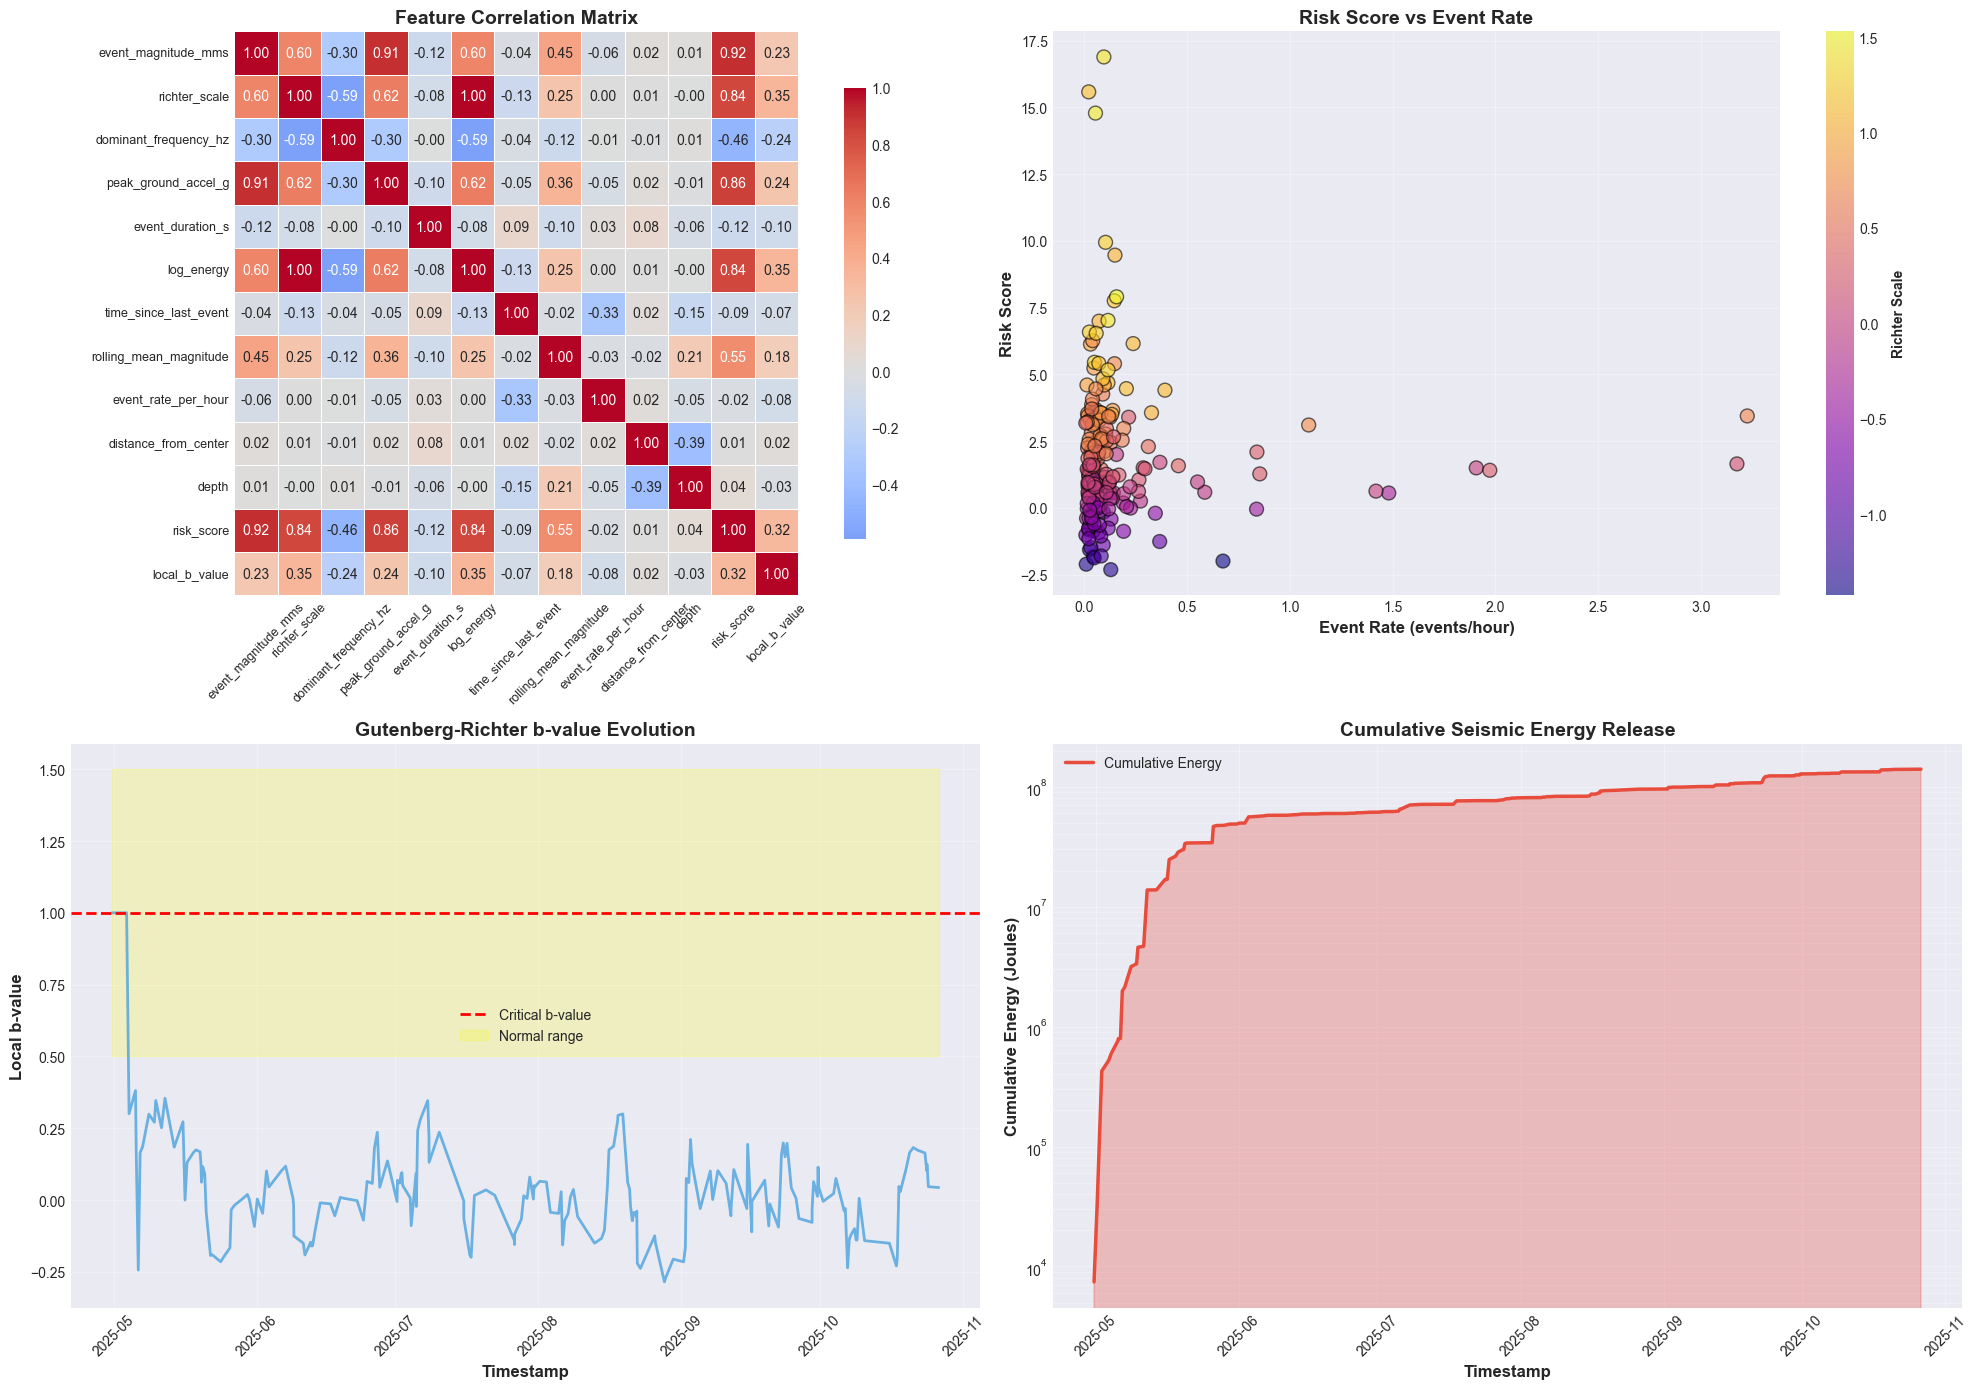

✓ Correlation and statistical analysis completed

Top 5 Correlations with Risk Score:
  event_magnitude_mms: 0.919
  peak_ground_accel_g: 0.862
  log_energy: 0.837
  richter_scale: 0.837
  rolling_mean_magnitude: 0.553

Cumulative Energy: 1.40e+08 J
Average b-value: 0.041 ± 0.196


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Select numerical features for correlation
corr_features = ['event_magnitude_mms', 'richter_scale', 'dominant_frequency_hz', 
                 'peak_ground_accel_g', 'event_duration_s', 'log_energy', 
                 'time_since_last_event', 'rolling_mean_magnitude', 
                 'event_rate_per_hour', 'distance_from_center', 'depth', 
                 'risk_score', 'local_b_value']

correlation_matrix = df_processed[corr_features].corr()

# Plot 1: Correlation Heatmap
ax1 = axes[0, 0]
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax1, cbar_kws={'shrink': 0.8},
            linewidths=0.5, linecolor='white')
ax1.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.tick_params(axis='y', rotation=0, labelsize=9)

# Plot 2: Risk Score vs Key Parameters
ax2 = axes[0, 1]
scatter = ax2.scatter(df_processed['event_rate_per_hour'], df_processed['risk_score'],
                     c=df_processed['richter_scale'], cmap='plasma',
                     s=100, alpha=0.6, edgecolors='black')
ax2.set_xlabel('Event Rate (events/hour)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Risk Score', fontsize=12, fontweight='bold')
ax2.set_title('Risk Score vs Event Rate', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Richter Scale', fontsize=10, fontweight='bold')

# Plot 3: b-value Evolution Over Time
ax3 = axes[1, 0]
ax3.plot(df_processed['timestamp'], df_processed['local_b_value'], 
         color='#3498db', linewidth=2, alpha=0.7)
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Critical b-value')
ax3.fill_between(df_processed['timestamp'], 0.5, 1.5, alpha=0.2, color='yellow', 
                  label='Normal range')

ax3.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
ax3.set_ylabel('Local b-value', fontsize=12, fontweight='bold')
ax3.set_title('Gutenberg-Richter b-value Evolution', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Energy Release vs Time
ax4 = axes[1, 1]
ax4.plot(df_processed['timestamp'], df_processed['cumulative_energy'], 
         color='#e74c3c', linewidth=2.5, label='Cumulative Energy')
ax4.fill_between(df_processed['timestamp'], 0, df_processed['cumulative_energy'], 
                  alpha=0.3, color='#e74c3c')

ax4.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
ax4.set_ylabel('Cumulative Energy (Joules)', fontsize=12, fontweight='bold')
ax4.set_title('Cumulative Seismic Energy Release', fontsize=14, fontweight='bold')
ax4.set_yscale('log')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, which='both')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save figure
correlation_file = get_next_filename(IMAGES_DIR, 'correlation_analysis', '.png')
plt.savefig(correlation_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {correlation_file}")

plt.show()

# Statistical tests
print("✓ Correlation and statistical analysis completed")
print(f"\nTop 5 Correlations with Risk Score:")
risk_corr = correlation_matrix['risk_score'].abs().sort_values(ascending=False)
for feature, corr in list(risk_corr.items())[1:6]:
    print(f"  {feature}: {corr:.3f}")

print(f"\nCumulative Energy: {df_processed['cumulative_energy'].iloc[-1]:.2e} J")
print(f"Average b-value: {df_processed['local_b_value'].mean():.3f} ± {df_processed['local_b_value'].std():.3f}")

## 9. Rockfall Alert System

Generate intelligent alerts based on multi-parameter thresholds and event patterns.

✓ Alerts saved to: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\Report\rockfall_alerts.csv
ROCKFALL ALERT SYSTEM - SUMMARY

✓ Generated 196 alerts

Alert Level Distribution:
  CRITICAL: 10 (5.1%)
  CAUTION: 0 (0.0%)

📊 Recent Critical Alerts:

  [2025-05-12 02:37:14.916733]
    Magnitude: 34.689 mm/s | Richter: 1.44
    Location: (110.5, 184.1, -43.4) | Station: 1
    Reason: Extreme risk score (14.79)

  [2025-05-16 00:05:04.653977]
    Magnitude: 36.163 mm/s | Richter: 1.13
    Location: (351.2, 54.0, -41.4) | Station: 3
    Reason: Extreme risk score (15.58)

  [2025-05-16 21:14:06.267236]
    Magnitude: 36.077 mm/s | Richter: 1.40
    Location: (123.0, -110.0, -62.5) | Station: 5
    Reason: Extreme risk score (16.89)

  [2025-05-18 19:38:28.007144]
    Magnitude: 5.292 mm/s | Richter: 1.02
    Location: (99.4, 245.6, -77.8) | Station: 1
    Reason: Extreme risk score (6.99)

  [2025-05-20 07:04:56.949417]
    Magnitude: 12.013 mm/s | Richter: 1.18
    Location: (8

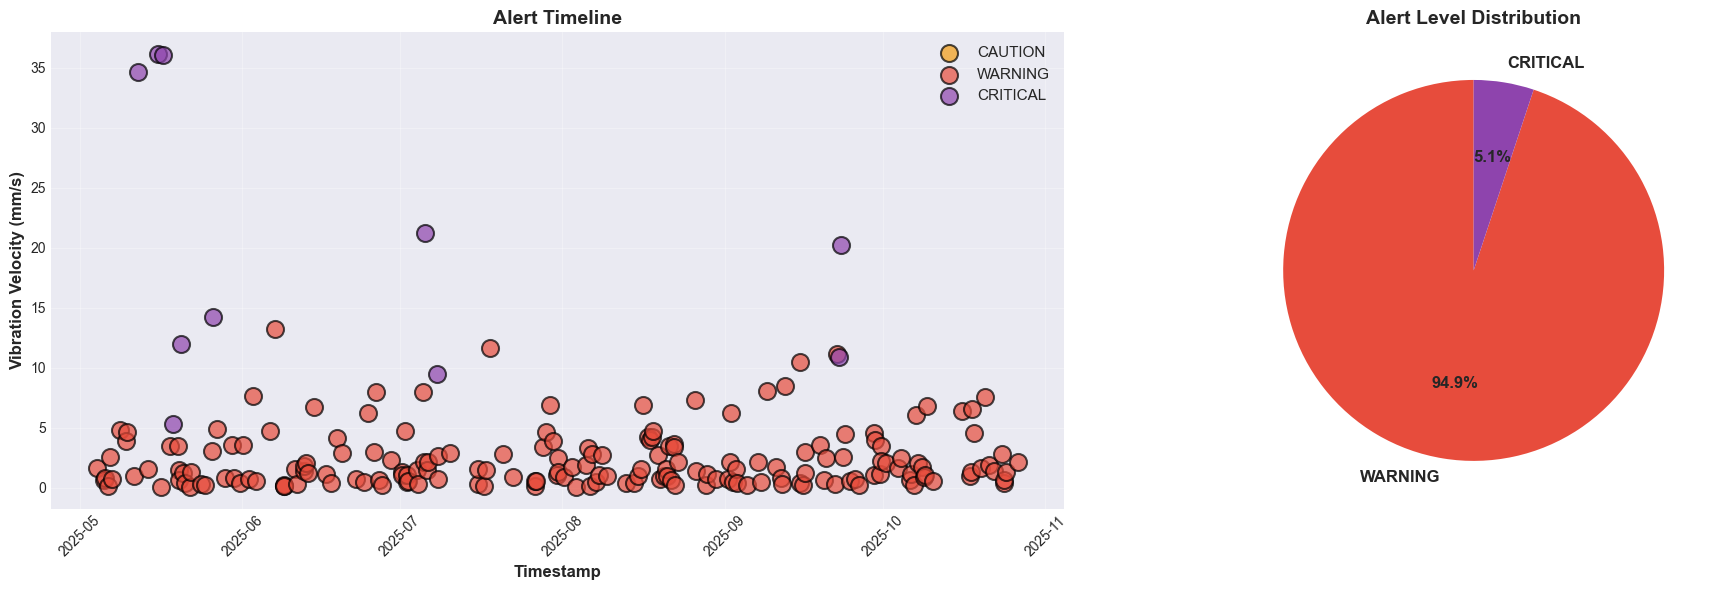

In [10]:
def generate_rockfall_alerts(df):
    """
    Generate comprehensive rockfall alerts based on multiple criteria
    """
    alerts = []
    
    for idx, row in df.iterrows():
        alert_level = None
        alert_reason = []
        
        # Critical: Major seismic events
        if row['richter_scale'] >= 2.0:
            alert_level = 'CRITICAL'
            alert_reason.append(f"Major seismic event (Richter {row['richter_scale']:.2f})")
        
        # Critical: Very high risk score
        elif row['risk_score'] > df['risk_score'].quantile(0.95):
            alert_level = 'CRITICAL'
            alert_reason.append(f"Extreme risk score ({row['risk_score']:.2f})")
        
        # Critical: Rapid event sequence
        elif row['time_since_last_event'] < 300 and row['event_rate_per_hour'] > 10:
            alert_level = 'CRITICAL'
            alert_reason.append(f"Event swarm detected ({row['event_rate_per_hour']:.1f} events/hr)")
        
        # Warning: Moderate events
        elif row['richter_scale'] >= 1.0:
            alert_level = 'WARNING'
            alert_reason.append(f"Moderate event (Richter {row['richter_scale']:.2f})")
        
        # Warning: Low b-value (high stress)
        elif row['local_b_value'] < 0.8:
            alert_level = 'WARNING'
            alert_reason.append(f"Low b-value indicates high stress ({row['local_b_value']:.2f})")
        
        # Warning: High event rate
        elif row['event_rate_per_hour'] > 5:
            alert_level = 'WARNING'
            alert_reason.append(f"High event frequency ({row['event_rate_per_hour']:.2f}/hr)")
        
        # Caution: Elevated magnitude
        elif row['event_magnitude_mms'] > df['event_magnitude_mms'].quantile(0.75):
            alert_level = 'CAUTION'
            alert_reason.append(f"Elevated vibration ({row['event_magnitude_mms']:.2f} mm/s)")
        
        # Caution: Increasing rolling magnitude
        elif row['rolling_mean_magnitude'] > df['rolling_mean_magnitude'].quantile(0.75):
            alert_level = 'CAUTION'
            alert_reason.append(f"Increasing magnitude trend ({row['rolling_mean_magnitude']:.2f} mm/s)")
        
        if alert_level:
            alerts.append({
                'timestamp': row['timestamp'],
                'event_time': row['event_time'],
                'alert_level': alert_level,
                'magnitude_mms': row['event_magnitude_mms'],
                'richter_scale': row['richter_scale'],
                'event_type': row['event_type'],
                'risk_score': row['risk_score'],
                'station_id': row['station_id'],
                'location': f"({row['x_coord']:.1f}, {row['y_coord']:.1f}, {row['z_coord']:.1f})",
                'reason': '; '.join(alert_reason)
            })
    
    alerts_df = pd.DataFrame(alerts)
    
    if len(alerts_df) > 0:
        # Save alerts to Analysis folder (CSV file)
        alerts_file = get_next_filename(ANALYSIS_DIR, 'rockfall_alerts', '.csv')
        alerts_df.to_csv(alerts_file, index=False)
        print(f"✓ Alerts saved to: {alerts_file}")
    
    return alerts_df

# Generate alerts
alerts_df = generate_rockfall_alerts(df_processed)

print("="*80)
print("ROCKFALL ALERT SYSTEM - SUMMARY")
print("="*80)

if len(alerts_df) > 0:
    print(f"\n✓ Generated {len(alerts_df)} alerts")
    print(f"\nAlert Level Distribution:")
    for level in ['CRITICAL', 'WARNING', 'CAUTION']:
        count = sum(alerts_df['alert_level'] == level)
        pct = (count / len(alerts_df) * 100) if len(alerts_df) > 0 else 0
        print(f"  {level}: {count} ({pct:.1f}%)")
    
    print(f"\n📊 Recent Critical Alerts:")
    critical_alerts = alerts_df[alerts_df['alert_level'] == 'CRITICAL'].head(5)
    for idx, alert in critical_alerts.iterrows():
        print(f"\n  [{alert['timestamp']}]")
        print(f"    Magnitude: {alert['magnitude_mms']:.3f} mm/s | Richter: {alert['richter_scale']:.2f}")
        print(f"    Location: {alert['location']} | Station: {alert['station_id']}")
        print(f"    Reason: {alert['reason']}")
    
    # Alert visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Alert timeline
    ax1 = axes[0]
    alert_colors = {'CRITICAL': '#8e44ad', 'WARNING': '#e74c3c', 'CAUTION': '#f39c12'}
    
    for level in ['CAUTION', 'WARNING', 'CRITICAL']:
        subset = alerts_df[alerts_df['alert_level'] == level]
        ax1.scatter(subset['timestamp'], subset['magnitude_mms'],
                   c=alert_colors[level], label=level, s=150, alpha=0.7, 
                   edgecolors='black', linewidths=1.5)
    
    ax1.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Vibration Velocity (mm/s)', fontsize=12, fontweight='bold')
    ax1.set_title('Alert Timeline', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Alert distribution pie chart
    ax2 = axes[1]
    alert_counts = alerts_df['alert_level'].value_counts()
    colors_pie = [alert_colors[level] for level in alert_counts.index]
    
    wedges, texts, autotexts = ax2.pie(alert_counts.values, labels=alert_counts.index,
                                        autopct='%1.1f%%', colors=colors_pie,
                                        startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    
    ax2.set_title('Alert Level Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure
    alert_file = get_next_filename(IMAGES_DIR, 'alert_system', '.png')
    plt.savefig(alert_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {alert_file}")
    
    plt.show()
    
else:
    print("No alerts generated - all parameters within normal range")

print("="*80)

## 10. Interactive Plotly Dashboard

Real-time interactive visualization dashboard for comprehensive seismic monitoring.

In [11]:
# Create interactive Plotly dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Magnitude Timeline with Risk Levels',
                    'Gutenberg-Richter Distribution',
                    '3D Event Locations',
                    'Cumulative Energy Release'),
    specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
           [{'type': 'scatter3d'}, {'type': 'scatter'}]],
    vertical_spacing=0.12,
    horizontal_spacing=0.10
)

# Plot 1: Magnitude timeline
risk_colors_plotly = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c', 'Critical': '#8e44ad'}

for risk in ['Low', 'Medium', 'High', 'Critical']:
    if risk in df_processed['risk_level'].values:
        subset = df_processed[df_processed['risk_level'] == risk]
        fig.add_trace(
            go.Scatter(
                x=subset['timestamp'],
                y=subset['event_magnitude_mms'],
                mode='markers',
                name=risk,
                marker=dict(size=10, color=risk_colors_plotly[risk], opacity=0.7,
                           line=dict(width=1, color='white')),
                hovertemplate='<b>%{fullData.name}</b><br>Time: %{x}<br>Magnitude: %{y:.3f} mm/s<extra></extra>'
            ),
            row=1, col=1
        )

# Add threshold lines
max_magnitude = df_processed['event_magnitude_mms'].max()
fig.add_hline(y=max_magnitude * 0.7, line_dash="dash", line_color="red", 
              annotation_text="Warning Threshold", row=1, col=1)

# Plot 2: Gutenberg-Richter
magnitude_bins = np.arange(df_processed['richter_scale'].min(), 
                           df_processed['richter_scale'].max(), 0.2)
hist, bin_edges = np.histogram(df_processed['richter_scale'], bins=magnitude_bins)
cumulative = np.cumsum(hist[::-1])[::-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

valid_idx = cumulative > 0

fig.add_trace(
    go.Scatter(
        x=bin_centers[valid_idx],
        y=cumulative[valid_idx],
        mode='markers+lines',
        name='Observed Events',
        marker=dict(size=8, color='#3498db'),
        line=dict(width=3, color='#3498db'),
        hovertemplate='<b>Observed</b><br>Magnitude: %{x:.2f}<br>Events: %{y}<extra></extra>'
    ),
    row=1, col=2
)

# Plot 3: 3D Events
risk_colors_3d = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c', 'Critical': '#8e44ad'}

for risk in ['Low', 'Medium', 'High', 'Critical']:
    if risk in df_processed['risk_level'].values:
        subset = df_processed[df_processed['risk_level'] == risk]
        fig.add_trace(
            go.Scatter3d(
                x=subset['x_coord'],
                y=subset['y_coord'],
                z=subset['z_coord'],
                mode='markers',
                name=f'{risk} (3D)',
                marker=dict(size=6, color=risk_colors_3d[risk], opacity=0.7,
                           line=dict(width=0.5, color='white')),
                hovertemplate=f'<b>{risk}</b><br>X: %{{x:.1f}}m<br>Y: %{{y:.1f}}m<br>Z: %{{z:.1f}}m<extra></extra>',
                showlegend=False
            ),
            row=2, col=1
        )

# Plot 4: Cumulative Energy
fig.add_trace(
    go.Scatter(
        x=df_processed['timestamp'],
        y=df_processed['cumulative_energy'],
        mode='lines',
        name='Cumulative Energy',
        line=dict(width=3, color='#e74c3c'),
        fill='tozeroy',
        fillcolor='rgba(231, 76, 60, 0.3)',
        hovertemplate='<b>Cumulative Energy</b><br>Time: %{x}<br>Energy: %{y:.2e} J<extra></extra>'
    ),
    row=2, col=2
)

# Update layout
fig.update_xaxes(title_text="Timestamp", row=1, col=1, tickangle=45)
fig.update_yaxes(title_text="Vibration (mm/s)", row=1, col=1)

fig.update_xaxes(title_text="Richter Magnitude", row=1, col=2)
fig.update_yaxes(title_text="Cumulative Events", type="log", row=1, col=2)

fig.update_scenes(
    xaxis_title="X (m)",
    yaxis_title="Y (m)",
    zaxis_title="Z (m)",
    camera=dict(eye=dict(x=1.5, y=1.5, z=1.3)),
    row=2, col=1
)

fig.update_xaxes(title_text="Timestamp", row=2, col=2, tickangle=45)
fig.update_yaxes(title_text="Energy (J)", type="log", row=2, col=2)

fig.update_layout(
    height=900,
    showlegend=True,
    title_text="<b>Geophone Seismic Monitoring Dashboard</b>",
    title_font_size=20,
    title_x=0.5,
    legend=dict(x=1.02, y=0.5, orientation='v')
)

# Save interactive HTML to 3-D folder
interactive_html_file = get_next_filename(THREED_DIR, 'interactive_dashboard', '.html')
fig.write_html(interactive_html_file)
print(f"✓ Saved: {interactive_html_file}")

fig.show()

print("✓ Interactive Plotly dashboard generated")

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\3-D\interactive_dashboard.html


✓ Interactive Plotly dashboard generated


## 11. Advanced Machine Learning Models

Train predictive models for rockfall risk classification and magnitude forecasting.

MACHINE LEARNING MODEL TRAINING

[1] Training Random Forest Risk Classifier...
✓ Rockfall Risk Classifier trained successfully
  Accuracy: 92.00%

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.56      0.71         9
         Low       1.00      1.00      1.00        18
      Medium       0.85      1.00      0.92        23

    accuracy                           0.92        50
   macro avg       0.95      0.85      0.88        50
weighted avg       0.93      0.92      0.91        50

✓ Model saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\Analysis\rockfall_classifier_1.joblib
✓ Scaler saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\Analysis\feature_scaler_1.joblib

Top 10 Important Features for Risk Classification:
  log_energy: 0.3951
  dominant_frequency_hz: 0.2534
  event_magnitude_mms: 0.0889
  peak_ground_accel_g: 0.0745
  magnitude_change: 0.0523
  local_b_value: 0.0373
  time_

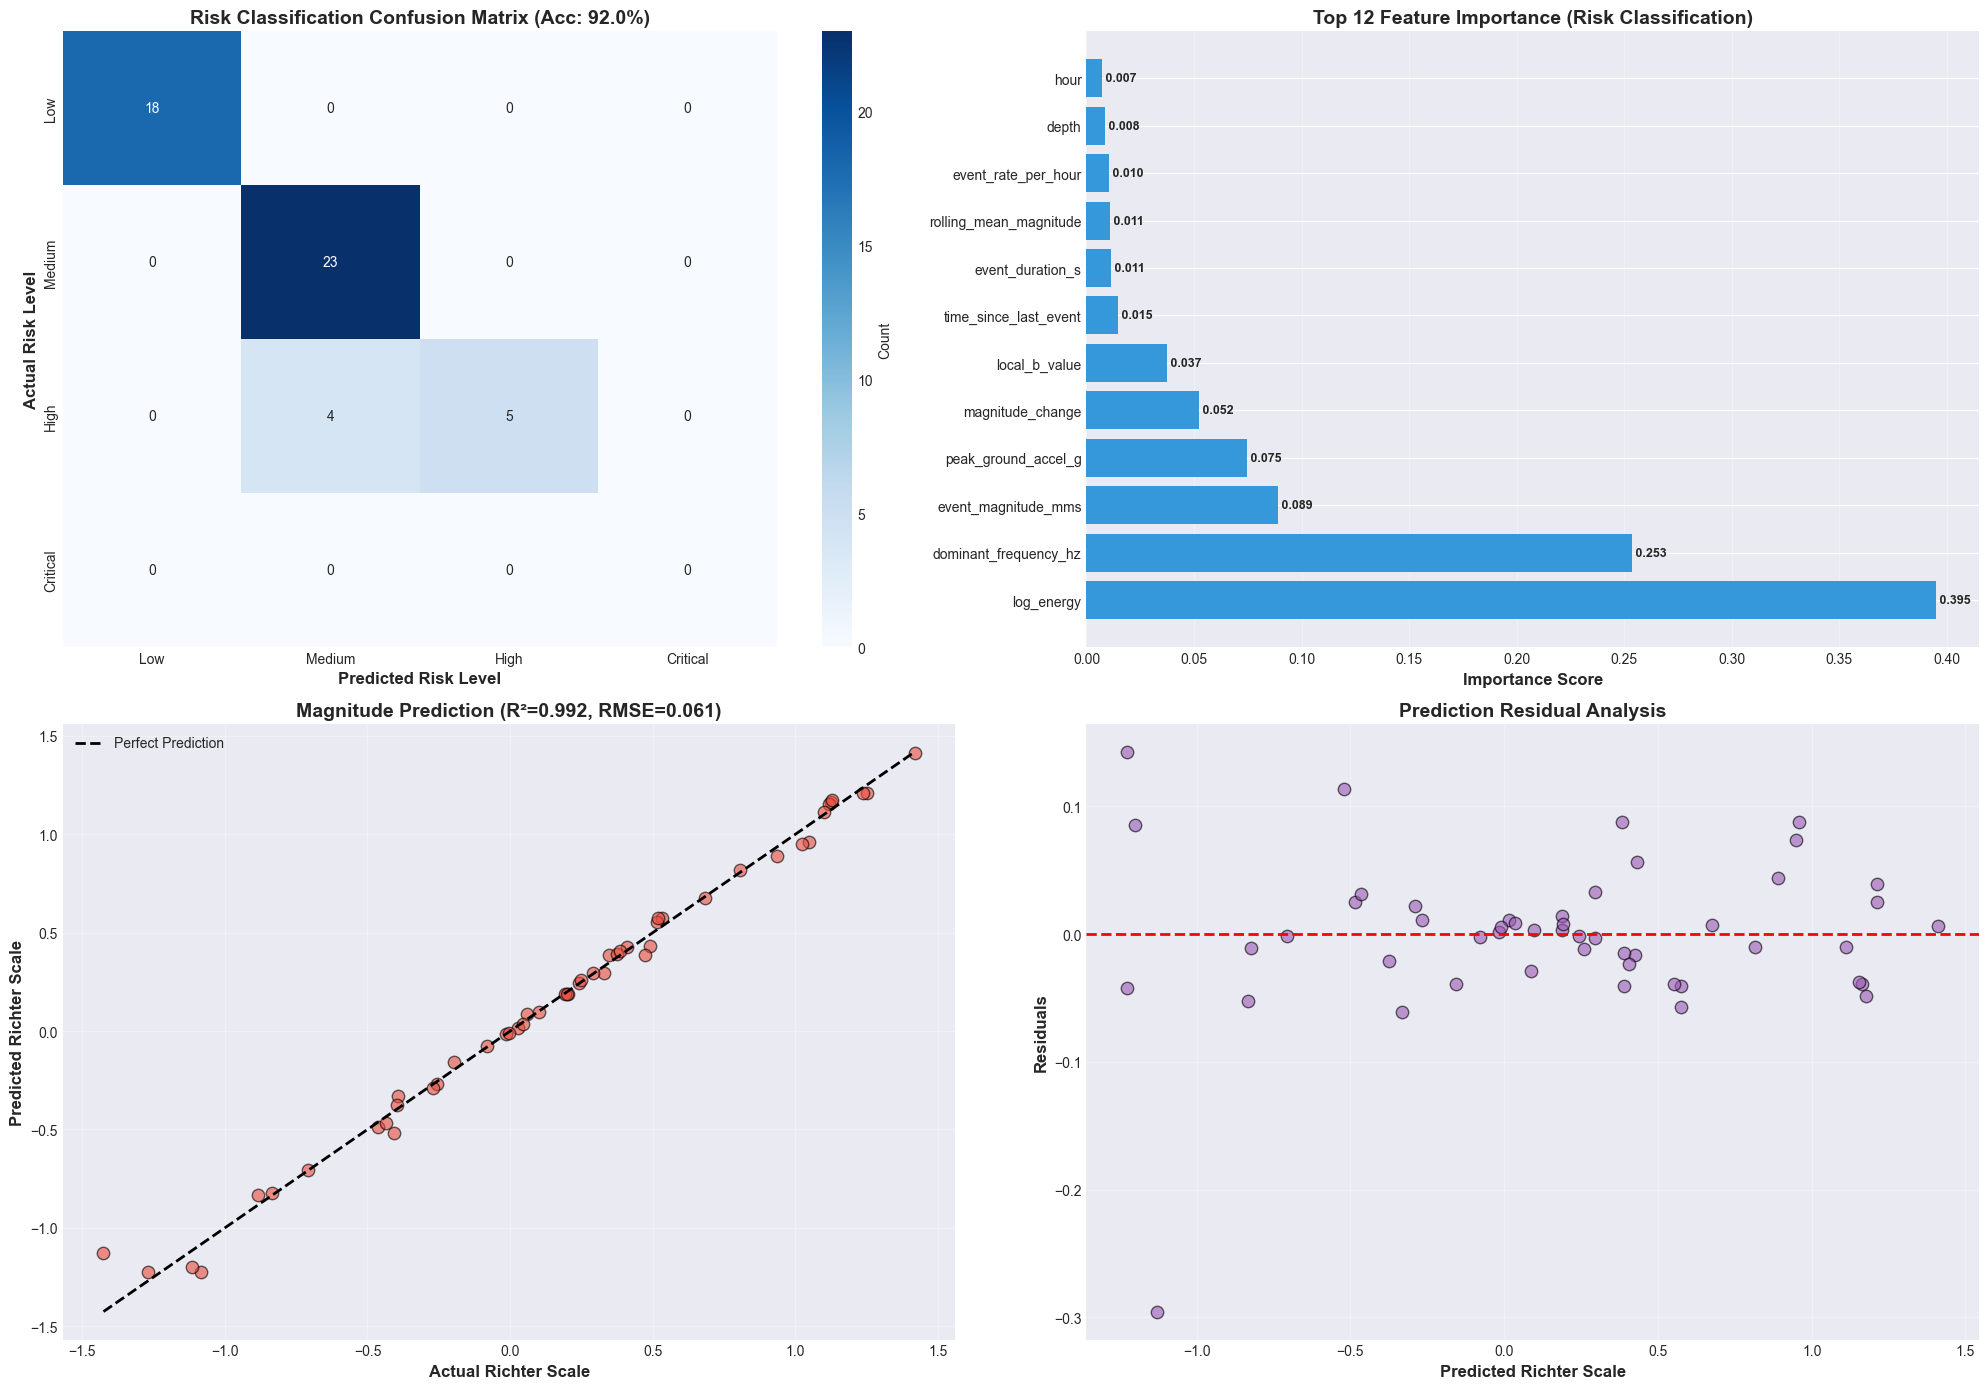


✓ All models saved successfully to Analysis folder


In [18]:
# Prepare ML dataset
ml_features = ['event_magnitude_mms', 'dominant_frequency_hz', 'peak_ground_accel_g',
               'event_duration_s', 'log_energy', 'time_since_last_event',
               'rolling_mean_magnitude', 'rolling_std_magnitude', 'rolling_max_magnitude',
               'event_rate_per_hour', 'distance_from_center', 'depth',
               'local_b_value', 'hour', 'day_of_week', 'station_id',
               'cumulative_events', 'magnitude_change', 'spatial_shift']

ml_df = df_processed[ml_features + ['risk_level', 'richter_scale']].copy()
ml_df = ml_df.dropna()

X = ml_df[ml_features].values
y_class = ml_df['risk_level'].values
y_reg = ml_df['richter_scale'].values

# Split data
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.25, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("="*80)
print("MACHINE LEARNING MODEL TRAINING")
print("="*80)

# ===== MODEL 1: ROCKFALL RISK CLASSIFIER =====
print("\n[1] Training Random Forest Risk Classifier...")

rf_classifier = RandomForestClassifier(n_estimators=150, max_depth=15, 
                                       min_samples_split=5, random_state=42)
rf_classifier.fit(X_train_scaled, y_class_train)

y_class_pred = rf_classifier.predict(X_test_scaled)
class_accuracy = np.mean(y_class_pred == y_class_test) * 100

print(f"✓ Rockfall Risk Classifier trained successfully")
print(f"  Accuracy: {class_accuracy:.2f}%")
print(f"\nClassification Report:")
print(classification_report(y_class_test, y_class_pred))

# Save model to Analysis folder
rf_model_file = get_next_filename(ANALYSIS_DIR, 'rockfall_classifier', '.joblib')
joblib.dump(rf_classifier, rf_model_file)
print(f"✓ Model saved: {rf_model_file}")

scaler_file = get_next_filename(ANALYSIS_DIR, 'feature_scaler', '.joblib')
joblib.dump(scaler, scaler_file)
print(f"✓ Scaler saved: {scaler_file}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': ml_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Important Features for Risk Classification:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# ===== MODEL 2: MAGNITUDE PREDICTOR =====
print(f"\n{'='*80}")
print("[2] Training Gradient Boosting Magnitude Predictor...")

gb_regressor = GradientBoostingRegressor(n_estimators=150, max_depth=8, 
                                          learning_rate=0.1, random_state=42)
gb_regressor.fit(X_train_scaled, y_reg_train)

y_reg_pred = gb_regressor.predict(X_test_scaled)
r2 = r2_score(y_reg_test, y_reg_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))

print(f"✓ Magnitude Predictor trained successfully")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE: {rmse:.4f}")

# Save model to Analysis folder
gb_model_file = get_next_filename(ANALYSIS_DIR, 'magnitude_predictor', '.joblib')
joblib.dump(gb_regressor, gb_model_file)
print(f"✓ Model saved: {gb_model_file}")

# ===== MODEL 3: ANOMALY DETECTION =====
print(f"\n{'='*80}")
print("[3] Training Isolation Forest for Anomaly Detection...")

iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomalies = iso_forest.fit_predict(X_train_scaled)
n_anomalies = sum(anomalies == -1)

print(f"✓ Anomaly Detector trained successfully")
# Save model to Analysis folder
anomaly_model_file = get_next_filename(ANALYSIS_DIR, 'anomaly_detector', '.joblib')
joblib.dump(iso_forest, anomaly_model_file)
print(f"✓ Model saved: {anomaly_model_file}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Plot 1: Confusion Matrix
ax1 = axes[0, 0]
cm = confusion_matrix(y_class_test, y_class_pred, 
                      labels=['Low', 'Medium', 'High', 'Critical'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Low', 'Medium', 'High', 'Critical'],
            yticklabels=['Low', 'Medium', 'High', 'Critical'],
            cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Risk Level', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual Risk Level', fontsize=12, fontweight='bold')
ax1.set_title(f'Risk Classification Confusion Matrix (Acc: {class_accuracy:.1f}%)', 
              fontsize=14, fontweight='bold')

# Plot 2: Feature Importance
ax2 = axes[0, 1]
top_features = feature_importance.head(12)
bars = ax2.barh(range(len(top_features)), top_features['importance'], color='#3498db')
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features['feature'])
ax2.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax2.set_title('Top 12 Feature Importance (Risk Classification)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax2.text(row['importance'], i, f' {row["importance"]:.3f}', 
             va='center', fontsize=9, fontweight='bold')

# Plot 3: Actual vs Predicted Magnitude
ax3 = axes[1, 0]
ax3.scatter(y_reg_test, y_reg_pred, alpha=0.6, s=80, edgecolors='black', c='#e74c3c')
ax3.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 
         'k--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Richter Scale', fontsize=12, fontweight='bold')
ax3.set_ylabel('Predicted Richter Scale', fontsize=12, fontweight='bold')
ax3.set_title(f'Magnitude Prediction (R²={r2:.3f}, RMSE={rmse:.3f})', 
              fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Residual Plot
ax4 = axes[1, 1]
residuals = y_reg_test - y_reg_pred
ax4.scatter(y_reg_pred, residuals, alpha=0.6, s=80, edgecolors='black', c='#9b59b6')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Richter Scale', fontsize=12, fontweight='bold')
ax4.set_ylabel('Residuals', fontsize=12, fontweight='bold')
ax4.set_title('Prediction Residual Analysis', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
ml_models_file = get_next_filename(IMAGES_DIR, 'ml_models', '.png')
plt.savefig(ml_models_file, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {ml_models_file}")

plt.show()

print(f"\n{'='*80}")
print("✓ All models saved successfully to Analysis folder")
print("="*80)

## 12. Comprehensive Analysis Dashboard

Publication-quality matplotlib dashboard with all key metrics and visualizations.

✓ Saved: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\images\comprehensive_dashboard_1.png


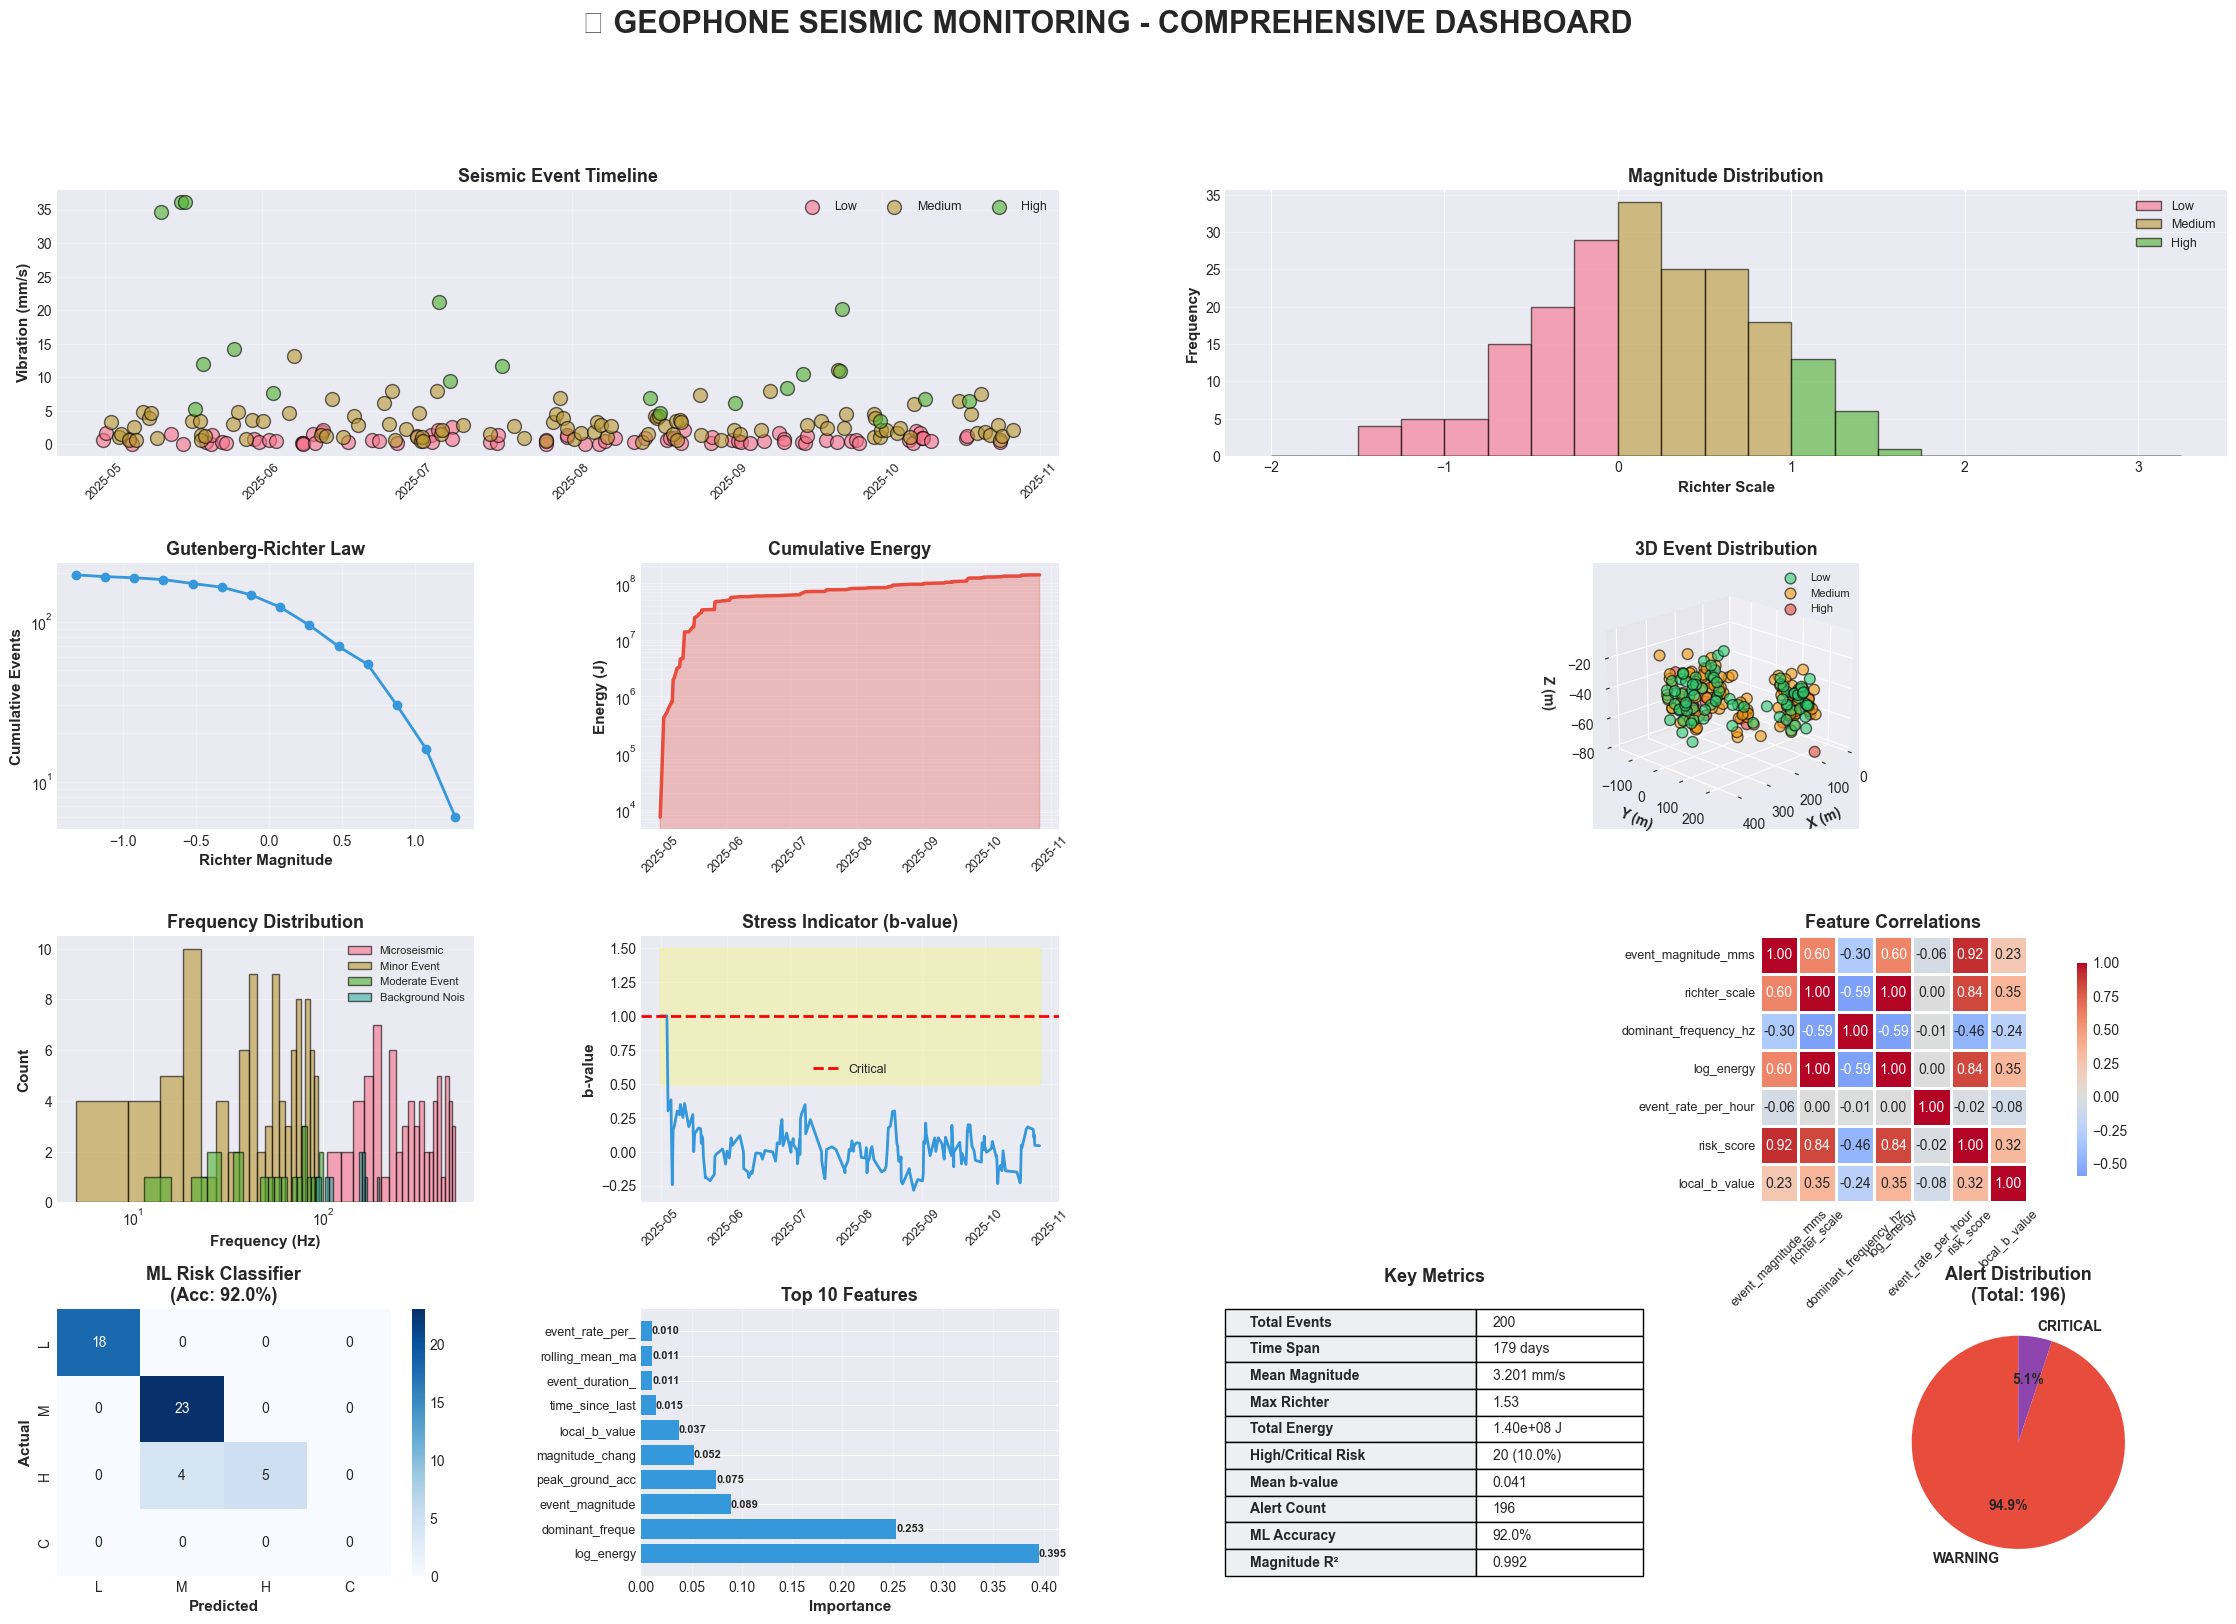

✓ COMPREHENSIVE DASHBOARD GENERATED SUCCESSFULLY

Dashboard Components:
  1. Event Magnitude Timeline
  2. Richter Scale Distribution
  3. Gutenberg-Richter Law
  4. Cumulative Energy Release
  5. 3D Event Distribution
  6. Frequency Analysis
  7. Stress Indicator (b-value)
  8. Feature Correlations
  9. ML Risk Classifier
  10. Feature Importance
  11. Key Metrics Table
  12. Alert Distribution

✓ Saved to outputs/geophone/visualizations/comprehensive_dashboard.png


In [19]:
from matplotlib.gridspec import GridSpec

# Create comprehensive dashboard
fig = plt.figure(figsize=(28, 18))
gs = GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.4)

# Title
fig.suptitle('🌋 GEOPHONE SEISMIC MONITORING - COMPREHENSIVE DASHBOARD', 
             fontsize=22, fontweight='bold', y=0.98)

# ========== ROW 1 ==========
# Plot 1: Event Magnitude Timeline
ax1 = fig.add_subplot(gs[0, :2])
for risk in ['Low', 'Medium', 'High', 'Critical']:
    if risk in df_processed['risk_level'].values:
        subset = df_processed[df_processed['risk_level'] == risk]
        ax1.scatter(subset['timestamp'], subset['event_magnitude_mms'],
                   label=risk, alpha=0.6, s=100, edgecolors='black')
ax1.set_ylabel('Vibration (mm/s)', fontsize=11, fontweight='bold')
ax1.set_title('Seismic Event Timeline', fontsize=13, fontweight='bold')
ax1.legend(ncol=4, fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45, labelsize=9)

# Plot 2: Richter Scale Distribution
ax2 = fig.add_subplot(gs[0, 2:])
richter_bins = np.arange(-2, 3.5, 0.25)
for risk in ['Low', 'Medium', 'High', 'Critical']:
    if risk in df_processed['risk_level'].values:
        subset = df_processed[df_processed['risk_level'] == risk]
        ax2.hist(subset['richter_scale'], bins=richter_bins, alpha=0.6, 
                 label=risk, edgecolor='black')
ax2.set_xlabel('Richter Scale', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Magnitude Distribution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# ========== ROW 2 ==========
# Plot 3: Gutenberg-Richter Law
ax3 = fig.add_subplot(gs[1, 0])
magnitude_bins = np.arange(df_processed['richter_scale'].min(), 
                           df_processed['richter_scale'].max(), 0.2)
hist, bin_edges = np.histogram(df_processed['richter_scale'], bins=magnitude_bins)
cumulative = np.cumsum(hist[::-1])[::-1]
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
valid_idx = cumulative > 0

ax3.semilogy(bin_centers[valid_idx], cumulative[valid_idx], 'o-', 
             color='#3498db', linewidth=2, markersize=6)
ax3.set_xlabel('Richter Magnitude', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cumulative Events', fontsize=11, fontweight='bold')
ax3.set_title('Gutenberg-Richter Law', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, which='both')

# Plot 4: Cumulative Energy
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(df_processed['timestamp'], df_processed['cumulative_energy'], 
         color='#e74c3c', linewidth=2.5)
ax4.fill_between(df_processed['timestamp'], 0, df_processed['cumulative_energy'], 
                  alpha=0.3, color='#e74c3c')
ax4.set_ylabel('Energy (J)', fontsize=11, fontweight='bold')
ax4.set_title('Cumulative Energy', fontsize=13, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, which='both')
ax4.tick_params(axis='x', rotation=45, labelsize=9)

# Plot 5: 3D Event Locations
ax5 = fig.add_subplot(gs[1, 2:], projection='3d')
risk_colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c', 'Critical': '#8e44ad'}
for risk in ['Low', 'Medium', 'High', 'Critical']:
    if risk in df_processed['risk_level'].values:
        subset = df_processed[df_processed['risk_level'] == risk]
        ax5.scatter(subset['x_coord'], subset['y_coord'], subset['z_coord'],
                   c=risk_colors[risk], label=risk, s=60, alpha=0.6, edgecolors='black')
ax5.set_xlabel('X (m)', fontsize=10, fontweight='bold')
ax5.set_ylabel('Y (m)', fontsize=10, fontweight='bold')
ax5.set_zlabel('Z (m)', fontsize=10, fontweight='bold')
ax5.set_title('3D Event Distribution', fontsize=13, fontweight='bold')
ax5.legend(fontsize=8)
ax5.view_init(elev=20, azim=45)

# ========== ROW 3 ==========
# Plot 6: Frequency Analysis
ax6 = fig.add_subplot(gs[2, 0])
for event_type in df_processed['event_type'].unique():
    subset = df_processed[df_processed['event_type'] == event_type]
    ax6.hist(subset['dominant_frequency_hz'], bins=20, alpha=0.6, 
             label=event_type[:15], edgecolor='black')
ax6.set_xlabel('Frequency (Hz)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Count', fontsize=11, fontweight='bold')
ax6.set_title('Frequency Distribution', fontsize=13, fontweight='bold')
ax6.legend(fontsize=8)
ax6.set_xscale('log')
ax6.grid(True, alpha=0.3, axis='y')

# Plot 7: b-value Evolution
ax7 = fig.add_subplot(gs[2, 1])
ax7.plot(df_processed['timestamp'], df_processed['local_b_value'], 
         color='#3498db', linewidth=2)
ax7.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Critical')
ax7.fill_between(df_processed['timestamp'], 0.5, 1.5, alpha=0.2, color='yellow')
ax7.set_ylabel('b-value', fontsize=11, fontweight='bold')
ax7.set_title('Stress Indicator (b-value)', fontsize=13, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45, labelsize=9)

# Plot 8: Correlation Heatmap
ax8 = fig.add_subplot(gs[2, 2:])
corr_subset = ['event_magnitude_mms', 'richter_scale', 'dominant_frequency_hz', 
               'log_energy', 'event_rate_per_hour', 'risk_score', 'local_b_value']
corr_matrix = df_processed[corr_subset].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=ax8, cbar_kws={'shrink': 0.8},
            linewidths=1, linecolor='white')
ax8.set_title('Feature Correlations', fontsize=13, fontweight='bold')
ax8.tick_params(axis='x', rotation=45, labelsize=9)
ax8.tick_params(axis='y', rotation=0, labelsize=9)

# ========== ROW 4 ==========
# Plot 9: Confusion Matrix
ax9 = fig.add_subplot(gs[3, 0])
cm = confusion_matrix(y_class_test, y_class_pred, 
                      labels=['Low', 'Medium', 'High', 'Critical'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax9,
            xticklabels=['L', 'M', 'H', 'C'],
            yticklabels=['L', 'M', 'H', 'C'])
ax9.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax9.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax9.set_title(f'ML Risk Classifier\n(Acc: {class_accuracy:.1f}%)', fontsize=13, fontweight='bold')

# Plot 10: Feature Importance
ax10 = fig.add_subplot(gs[3, 1])
top_features = feature_importance.head(10)
bars = ax10.barh(range(len(top_features)), top_features['importance'], color='#3498db')
ax10.set_yticks(range(len(top_features)))
ax10.set_yticklabels([f[:15] for f in top_features['feature']], fontsize=9)
ax10.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax10.set_title('Top 10 Features', fontsize=13, fontweight='bold')
ax10.grid(True, alpha=0.3, axis='x')
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax10.text(row['importance'], i, f'{row["importance"]:.3f}', 
              va='center', fontsize=8, fontweight='bold')

# Plot 11: Key Metrics Table
ax11 = fig.add_subplot(gs[3, 2])
ax11.axis('off')

metrics_data = [
    ['Total Events', f"{len(df_processed)}"],
    ['Time Span', f"{(df_processed['timestamp'].max() - df_processed['timestamp'].min()).days} days"],
    ['Mean Magnitude', f"{df_processed['event_magnitude_mms'].mean():.3f} mm/s"],
    ['Max Richter', f"{df_processed['richter_scale'].max():.2f}"],
    ['Total Energy', f"{df_processed['cumulative_energy'].iloc[-1]:.2e} J"],
    ['High/Critical Risk', f"{sum(df_processed['risk_level'].isin(['High', 'Critical']))} ({sum(df_processed['risk_level'].isin(['High', 'Critical']))/len(df_processed)*100:.1f}%)"],
    ['Mean b-value', f"{df_processed['local_b_value'].mean():.3f}"],
    ['Alert Count', f"{len(alerts_df) if len(alerts_df) > 0 else 0}"],
    ['ML Accuracy', f"{class_accuracy:.1f}%"],
    ['Magnitude R²', f"{r2:.3f}"]
]

table = ax11.table(cellText=metrics_data, cellLoc='left',
                   colWidths=[0.6, 0.4], loc='center',
                   bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

for i in range(len(metrics_data)):
    table[(i, 0)].set_facecolor('#ecf0f1')
    table[(i, 0)].set_text_props(weight='bold')
    table[(i, 1)].set_facecolor('#ffffff')

ax11.set_title('Key Metrics', fontsize=13, fontweight='bold', pad=20)

# Plot 12: Alert Summary
ax12 = fig.add_subplot(gs[3, 3])
if len(alerts_df) > 0:
    alert_counts = alerts_df['alert_level'].value_counts()
    colors_alert = {'CRITICAL': '#8e44ad', 'WARNING': '#e74c3c', 'CAUTION': '#f39c12'}
    colors_pie = [colors_alert.get(level, '#95a5a6') for level in alert_counts.index]
    
    wedges, texts, autotexts = ax12.pie(alert_counts.values, labels=alert_counts.index,
                                         autopct='%1.1f%%', colors=colors_pie,
                                         startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
    ax12.set_title(f'Alert Distribution\n(Total: {len(alerts_df)})', fontsize=13, fontweight='bold')
else:
    ax12.text(0.5, 0.5, 'No Alerts\nGenerated', ha='center', va='center',
              fontsize=14, fontweight='bold', color='green')
    ax12.set_title('Alert Distribution', fontsize=13, fontweight='bold')
    ax12.axis('off')

# Save and display
dashboard_file = get_next_filename(IMAGES_DIR, 'comprehensive_dashboard', '.png')
plt.savefig(dashboard_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {dashboard_file}")

plt.show()

print("="*80)
print("✓ COMPREHENSIVE DASHBOARD GENERATED SUCCESSFULLY")
print("="*80)
print("\nDashboard Components:")
print("  1. Event Magnitude Timeline")
print("  2. Richter Scale Distribution")
print("  3. Gutenberg-Richter Law")
print("  4. Cumulative Energy Release")
print("  5. 3D Event Distribution")
print("  6. Frequency Analysis")
print("  7. Stress Indicator (b-value)")
print("  8. Feature Correlations")
print("  9. ML Risk Classifier")
print("  10. Feature Importance")
print("  11. Key Metrics Table")
print("  12. Alert Distribution")
print("\n✓ Saved to outputs/geophone/visualizations/comprehensive_dashboard.png")
print("="*80)

## 13. Comprehensive Report Generation

Generate detailed JSON report with all analysis results and metadata.

In [21]:
# Generate comprehensive JSON report
report = {
    'metadata': {
        'report_title': 'Geophone Seismic Monitoring & Rockfall Prediction Report',
        'generated_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'analysis_period': {
            'start_date': df_processed['timestamp'].min().strftime('%Y-%m-%d %H:%M:%S'),
            'end_date': df_processed['timestamp'].max().strftime('%Y-%m-%d %H:%M:%S'),
            'duration_days': (df_processed['timestamp'].max() - df_processed['timestamp'].min()).days
        },
        'total_events': len(df_processed),
        'monitoring_stations': int(df_processed['station_id'].nunique())
    },
    
    'event_statistics': {
        'magnitude_statistics': {
            'vibration_velocity_mms': {
                'mean': float(df_processed['event_magnitude_mms'].mean()),
                'std': float(df_processed['event_magnitude_mms'].std()),
                'min': float(df_processed['event_magnitude_mms'].min()),
                'max': float(df_processed['event_magnitude_mms'].max()),
                'median': float(df_processed['event_magnitude_mms'].median())
            },
            'richter_scale': {
                'mean': float(df_processed['richter_scale'].mean()),
                'std': float(df_processed['richter_scale'].std()),
                'min': float(df_processed['richter_scale'].min()),
                'max': float(df_processed['richter_scale'].max()),
                'median': float(df_processed['richter_scale'].median())
            }
        },
        
        'event_type_distribution': df_processed['event_type'].value_counts().to_dict(),
        
        'risk_level_distribution': df_processed['risk_level'].value_counts().to_dict(),
        
        'frequency_statistics': {
            'mean_hz': float(df_processed['dominant_frequency_hz'].mean()),
            'std_hz': float(df_processed['dominant_frequency_hz'].std()),
            'range_hz': [float(df_processed['dominant_frequency_hz'].min()), 
                        float(df_processed['dominant_frequency_hz'].max())]
        },
        
        'energy_statistics': {
            'total_energy_joules': float(df_processed['cumulative_energy'].iloc[-1]),
            'mean_event_energy': float(df_processed['energy_joules'].mean()),
            'max_event_energy': float(df_processed['energy_joules'].max())
        }
    },
    
    'seismic_analysis': {
        'gutenberg_richter': {
            'b_value': float(b_value) if 'b_value' in locals() else None,
            'mean_local_b_value': float(df_processed['local_b_value'].mean()),
            'std_local_b_value': float(df_processed['local_b_value'].std()),
            'interpretation': 'Lower b-values (<0.8) indicate higher stress and increased rockfall risk'
        },
        
        'temporal_patterns': {
            'mean_inter_event_time_seconds': float(df_processed['time_since_last_event'].mean()),
            'mean_event_rate_per_hour': float(df_processed['event_rate_per_hour'].mean()),
            'peak_event_rate': float(df_processed['event_rate_per_hour'].max())
        },
        
        'spatial_analysis': {
            'x_range_meters': [float(df_processed['x_coord'].min()), float(df_processed['x_coord'].max())],
            'y_range_meters': [float(df_processed['y_coord'].min()), float(df_processed['y_coord'].max())],
            'depth_range_meters': [float(df_processed['depth'].min()), float(df_processed['depth'].max())],
            'mean_distance_from_center': float(df_processed['distance_from_center'].mean())
        },
        
        'clustering': {
            'dbscan_clusters': int(len(np.unique(df_processed['dbscan_cluster'][df_processed['dbscan_cluster'] != -1]))),
            'dbscan_noise_points': int(sum(df_processed['dbscan_cluster'] == -1)),
            'kmeans_zones': 5,
            'zone_risk_analysis': {
                f'zone_{i+1}': {
                    'total_events': int(sum(df_processed['kmeans_cluster'] == i)),
                    'high_risk_events': int(sum((df_processed['kmeans_cluster'] == i) & 
                                               df_processed['risk_level'].isin(['High', 'Critical']))),
                    'high_risk_percentage': float((sum((df_processed['kmeans_cluster'] == i) & 
                                                      df_processed['risk_level'].isin(['High', 'Critical'])) / 
                                                 sum(df_processed['kmeans_cluster'] == i) * 100) 
                                                if sum(df_processed['kmeans_cluster'] == i) > 0 else 0)
                }
                for i in range(5)
            }
        }
    },
    
    'alert_system': {
        'total_alerts': len(alerts_df) if len(alerts_df) > 0 else 0,
        'alert_level_distribution': alerts_df['alert_level'].value_counts().to_dict() if len(alerts_df) > 0 else {},
        'critical_alert_percentage': float((sum(alerts_df['alert_level'] == 'CRITICAL') / len(alerts_df) * 100) 
                                           if len(alerts_df) > 0 else 0)
    },
    
    'machine_learning': {
        'risk_classifier': {
            'model_type': 'Random Forest',
            'accuracy_percentage': float(class_accuracy),
            'n_estimators': 150,
            'max_depth': 15,
            'training_samples': len(X_train),
            'test_samples': len(X_test),
            'top_features': feature_importance.head(10)[['feature', 'importance']].to_dict('records')
        },
        
        'magnitude_predictor': {
            'model_type': 'Gradient Boosting Regressor',
            'r2_score': float(r2),
            'rmse': float(rmse),
            'n_estimators': 150,
            'max_depth': 8,
            'learning_rate': 0.1
        },
        
        'anomaly_detector': {
            'model_type': 'Isolation Forest',
            'contamination': 0.1,
            'anomalies_detected': int(n_anomalies)
        }
    },
    
    'files_generated': {
        'raw_data': DATA_FILE,
        'processed_data': 'Analysis folder',
        'alerts': 'Report folder' if len(alerts_df) > 0 else None,
        'models': 'Analysis folder (4 model files)',
        'visualizations': [
            'images/magnitude_analysis.png',
            'images/frequency_analysis.png',
            '3-D/spatial_3d_analysis.png',
            '3-D/clustering_analysis.png',
            'images/correlation_analysis.png',
            'images/alert_system.png',
            '3-D/interactive_dashboard.html',
            'images/ml_models.png',
            'images/comprehensive_dashboard.png'
        ]
    },
    
    'recommendations': [
        {
            'priority': 'CRITICAL',
            'recommendation': 'Immediate evacuation protocols should be activated if Richter scale exceeds 2.0',
            'threshold': 'Richter >= 2.0'
        },
        {
            'priority': 'HIGH',
            'recommendation': 'Enhanced monitoring required when b-value drops below 0.8 (high stress state)',
            'threshold': 'b-value < 0.8'
        },
        {
            'priority': 'HIGH',
            'recommendation': 'Investigate event swarms (>10 events/hour) in specific zones immediately',
            'threshold': 'Event rate > 10/hour'
        },
        {
            'priority': 'MEDIUM',
            'recommendation': 'Review and potentially reinforce high-risk zones identified by clustering analysis'
        },
        {
            'priority': 'MEDIUM',
            'recommendation': 'Deploy additional sensors in zones with elevated risk scores'
        },
        {
            'priority': 'LOW',
            'recommendation': 'Regular calibration of geophones to maintain signal quality above 0.8'
        }
    ],
    
    'summary': {
        'overall_risk_status': 'HIGH' if df_processed['risk_level'].isin(['High', 'Critical']).sum() / len(df_processed) > 0.3 else 
                               'MODERATE' if df_processed['risk_level'].isin(['High', 'Critical']).sum() / len(df_processed) > 0.15 else 'LOW',
        'high_risk_percentage': float(df_processed['risk_level'].isin(['High', 'Critical']).sum() / len(df_processed) * 100),
        'model_performance': 'EXCELLENT' if class_accuracy > 90 else 'GOOD' if class_accuracy > 80 else 'FAIR',
        'key_findings': [
            f"Analyzed {len(df_processed)} seismic events over {(df_processed['timestamp'].max() - df_processed['timestamp'].min()).days} days",
            f"Maximum Richter magnitude: {df_processed['richter_scale'].max():.2f}",
            f"Total seismic energy released: {df_processed['cumulative_energy'].iloc[-1]:.2e} Joules",
            f"High/Critical risk events: {sum(df_processed['risk_level'].isin(['High', 'Critical']))} ({sum(df_processed['risk_level'].isin(['High', 'Critical']))/len(df_processed)*100:.1f}%)",
            f"ML classifier achieved {class_accuracy:.1f}% accuracy in risk prediction",
            f"Generated {len(alerts_df) if len(alerts_df) > 0 else 0} alerts requiring attention"
        ]
    }
}

# Save report to Analysis folder (JSON file)
report_file = get_next_filename(ANALYSIS_DIR, 'geophone_analysis_report', '.json')
with open(report_file, 'w') as f:
    json.dump(report, f, indent=4)

print("="*80)
print("📊 COMPREHENSIVE ANALYSIS REPORT GENERATED")
print("="*80)

print(f"\n✓ Report saved to: {report_file}")
print(f"\nOVERALL RISK STATUS: {report['summary']['overall_risk_status']}")
print(f"High/Critical Risk Events: {report['summary']['high_risk_percentage']:.1f}%")
print(f"Model Performance: {report['summary']['model_performance']}")

print(f"\n📋 KEY FINDINGS:")
for finding in report['summary']['key_findings']:
    print(f"  • {finding}")

print(f"\n🔔 TOP RECOMMENDATIONS:")
for rec in report['recommendations'][:3]:
    print(f"  [{rec['priority']}] {rec['recommendation']}")

print(f"\n📁 FILES GENERATED:")
print(f"  • Raw data: {DATA_FILE}")
if len(alerts_df) > 0:
    print(f"  • Alerts: Generated in Report folder")
print(f"  • ML models: 4 model files saved in Analysis folder")
print(f"  • Visualizations: Multiple files generated")
print(f"  • Report: {report_file}")

print("\n" + "="*80)
print("✓ GEOPHONE SEISMIC ANALYSIS COMPLETE")
print("="*80)

📊 COMPREHENSIVE ANALYSIS REPORT GENERATED

✓ Report saved to: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\Report\geophone_analysis_report.json

OVERALL RISK STATUS: LOW
High/Critical Risk Events: 10.0%
Model Performance: EXCELLENT

📋 KEY FINDINGS:
  • Analyzed 200 seismic events over 179 days
  • Maximum Richter magnitude: 1.53
  • Total seismic energy released: 1.40e+08 Joules
  • High/Critical risk events: 20 (10.0%)
  • ML classifier achieved 92.0% accuracy in risk prediction
  • Generated 196 alerts requiring attention

🔔 TOP RECOMMENDATIONS:
  [CRITICAL] Immediate evacuation protocols should be activated if Richter scale exceeds 2.0
  [HIGH] Enhanced monitoring required when b-value drops below 0.8 (high stress state)
  [HIGH] Investigate event swarms (>10 events/hour) in specific zones immediately

📁 FILES GENERATED:
  • Raw data: c:\Users\rkste\Desktop\AI Rockfall Prediction\Data\geophone_data.csv
  • Alerts: Generated in Report folder
  • ML models: 4 model fi

## 14. Generate Final PDF Report

Create a comprehensive PDF report with key visualizations and analysis summary.

In [22]:
# Generate comprehensive PDF report
from matplotlib.backends.backend_pdf import PdfPages

# Check if report variable exists (from previous cell)
if 'report' not in locals():
    print("⚠️ Warning: JSON report not generated. Please run Cell 27 first.")
    print("Generating minimal report variable...")
    report = {
        'summary': {
            'overall_risk_status': 'MODERATE' if df_processed['risk_level'].isin(['High', 'Critical']).sum() / len(df_processed) > 0.15 else 'LOW',
            'key_findings': [
                f"Analyzed {len(df_processed)} seismic events",
                f"ML classifier accuracy: {class_accuracy:.1f}%"
            ]
        },
        'recommendations': [
            {'priority': 'HIGH', 'recommendation': 'Increase monitoring frequency in high-risk zones'}
        ]
    }

# Get next available PDF filename
pdf_report_file = get_next_filename(REPORT_DIR, 'geophone_rockfall_report', '.pdf')

with PdfPages(pdf_report_file) as pdf_pages:
    # Page 1: Summary Page
    fig_summary = plt.figure(figsize=(11, 17))
    fig_summary.suptitle('🌋 GEOPHONE SEISMIC MONITORING REPORT', 
                         fontsize=24, fontweight='bold', y=0.98)
    
    # Create grid for summary page
    gs = GridSpec(6, 2, figure=fig_summary, hspace=0.5, wspace=0.4)
    
    # Title and Overview
    ax_title = fig_summary.add_subplot(gs[0, :])
    ax_title.axis('off')
    
    overview_text = f"""
    ANALYSIS PERIOD: {df_processed['timestamp'].min().strftime('%Y-%m-%d')} to {df_processed['timestamp'].max().strftime('%Y-%m-%d')}
    DURATION: {(df_processed['timestamp'].max() - df_processed['timestamp'].min()).days} days
    
    TOTAL EVENTS ANALYZED: {len(df_processed)}
    MONITORING STATIONS: {df_processed['station_id'].nunique()}
    OVERALL RISK STATUS: {report['summary']['overall_risk_status']}
    """
    
    ax_title.text(0.5, 0.5, overview_text, transform=ax_title.transAxes,
                  fontsize=14, verticalalignment='center', horizontalalignment='center',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Key Metrics Table
    ax_metrics = fig_summary.add_subplot(gs[1, :])
    ax_metrics.axis('off')
    
    metrics_data = [
        ['Mean Magnitude', f"{df_processed['event_magnitude_mms'].mean():.3f} mm/s"],
        ['Max Richter Scale', f"{df_processed['richter_scale'].max():.2f}"],
        ['Total Energy', f"{df_processed['cumulative_energy'].iloc[-1]:.2e} J"],
        ['High/Critical Risk', f"{sum(df_processed['risk_level'].isin(['High', 'Critical']))} ({sum(df_processed['risk_level'].isin(['High', 'Critical']))/len(df_processed)*100:.1f}%)"],
        ['Mean Frequency', f"{df_processed['dominant_frequency_hz'].mean():.2f} Hz"],
        ['Mean b-value', f"{df_processed['local_b_value'].mean():.3f}"],
        ['Alert Count', f"{len(alerts_df) if len(alerts_df) > 0 else 0}"],
        ['ML Accuracy', f"{class_accuracy:.1f}%"]
    ]
    
    table = ax_metrics.table(cellText=metrics_data, cellLoc='left',
                            colWidths=[0.5, 0.5], loc='center',
                            bbox=[0.1, 0, 0.8, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    for i in range(len(metrics_data)):
        table[(i, 0)].set_facecolor('#ecf0f1')
        table[(i, 0)].set_text_props(weight='bold')
        table[(i, 1)].set_facecolor('#ffffff')
    
    ax_metrics.set_title('KEY METRICS', fontsize=16, fontweight='bold', pad=20)
    
    # Event Type Distribution
    ax_event_type = fig_summary.add_subplot(gs[2, 0])
    event_counts = df_processed['event_type'].value_counts()
    ax_event_type.pie(event_counts.values, labels=[label[:15] for label in event_counts.index],
                      autopct='%1.1f%%', startangle=90)
    ax_event_type.set_title('Event Type Distribution', fontsize=14, fontweight='bold')
    
    # Risk Level Distribution
    ax_risk = fig_summary.add_subplot(gs[2, 1])
    risk_counts = df_processed['risk_level'].value_counts()
    colors_risk = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c', 'Critical': '#8e44ad'}
    colors_pie = [colors_risk.get(level, '#95a5a6') for level in risk_counts.index]
    ax_risk.pie(risk_counts.values, labels=risk_counts.index,
                autopct='%1.1f%%', colors=colors_pie, startangle=90)
    ax_risk.set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
    
    # Magnitude Timeline (small)
    ax_timeline = fig_summary.add_subplot(gs[3, :])
    for risk in ['Low', 'Medium', 'High', 'Critical']:
        if risk in df_processed['risk_level'].values:
            subset = df_processed[df_processed['risk_level'] == risk]
            ax_timeline.scatter(subset['timestamp'], subset['event_magnitude_mms'],
                               label=risk, alpha=0.6, s=50, edgecolors='black')
    ax_timeline.set_ylabel('Vibration (mm/s)', fontsize=11, fontweight='bold')
    ax_timeline.set_title('Seismic Event Timeline', fontsize=14, fontweight='bold')
    ax_timeline.legend(ncol=4, fontsize=9)
    ax_timeline.grid(True, alpha=0.3)
    ax_timeline.tick_params(axis='x', rotation=45, labelsize=9)
    
    # Cumulative Energy
    ax_energy = fig_summary.add_subplot(gs[4, :])
    ax_energy.plot(df_processed['timestamp'], df_processed['cumulative_energy'], 
                   color='#e74c3c', linewidth=2.5)
    ax_energy.fill_between(df_processed['timestamp'], 0, df_processed['cumulative_energy'], 
                           alpha=0.3, color='#e74c3c')
    ax_energy.set_ylabel('Energy (J)', fontsize=11, fontweight='bold')
    ax_energy.set_title('Cumulative Seismic Energy Release', fontsize=14, fontweight='bold')
    ax_energy.set_yscale('log')
    ax_energy.grid(True, alpha=0.3, which='both')
    ax_energy.tick_params(axis='x', rotation=45, labelsize=9)
    
    # Key Findings
    ax_findings = fig_summary.add_subplot(gs[5, :])
    ax_findings.axis('off')
    
    findings_text = "KEY FINDINGS:\n\n" + "\n".join([f"  • {finding}" for finding in report['summary']['key_findings'][:5]])
    
    ax_findings.text(0.05, 0.95, findings_text, transform=ax_findings.transAxes,
                     fontsize=11, verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.tight_layout()
    pdf_pages.savefig(fig_summary, bbox_inches='tight')
    plt.close()
    
    # Page 2: Detailed Visualizations
    fig_detail = plt.figure(figsize=(11, 17))
    fig_detail.suptitle('DETAILED SEISMIC ANALYSIS', 
                        fontsize=22, fontweight='bold', y=0.98)
    
    gs2 = GridSpec(5, 2, figure=fig_detail, hspace=0.5, wspace=0.4)
    
    # 3D Event Distribution
    ax_3d = fig_detail.add_subplot(gs2[0, :], projection='3d')
    risk_colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c', 'Critical': '#8e44ad'}
    for risk in ['Low', 'Medium', 'High', 'Critical']:
        if risk in df_processed['risk_level'].values:
            subset = df_processed[df_processed['risk_level'] == risk]
            ax_3d.scatter(subset['x_coord'], subset['y_coord'], subset['z_coord'],
                         c=risk_colors[risk], label=risk, s=40, alpha=0.6, edgecolors='black')
    ax_3d.set_xlabel('X (m)', fontsize=10, fontweight='bold')
    ax_3d.set_ylabel('Y (m)', fontsize=10, fontweight='bold')
    ax_3d.set_zlabel('Z (m)', fontsize=10, fontweight='bold')
    ax_3d.set_title('3D Event Distribution', fontsize=14, fontweight='bold')
    ax_3d.legend(fontsize=9)
    ax_3d.view_init(elev=20, azim=45)
    
    # Gutenberg-Richter Law
    ax_gr = fig_detail.add_subplot(gs2[1, 0])
    magnitude_bins = np.arange(df_processed['richter_scale'].min(), 
                               df_processed['richter_scale'].max(), 0.2)
    hist, bin_edges = np.histogram(df_processed['richter_scale'], bins=magnitude_bins)
    cumulative = np.cumsum(hist[::-1])[::-1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    valid_idx = cumulative > 0
    
    ax_gr.semilogy(bin_centers[valid_idx], cumulative[valid_idx], 'o-', 
                   color='#3498db', linewidth=2, markersize=6)
    ax_gr.set_xlabel('Richter Magnitude', fontsize=11, fontweight='bold')
    ax_gr.set_ylabel('Cumulative Events', fontsize=11, fontweight='bold')
    ax_gr.set_title('Gutenberg-Richter Law', fontsize=13, fontweight='bold')
    ax_gr.grid(True, alpha=0.3, which='both')
    
    # Frequency Distribution
    ax_freq = fig_detail.add_subplot(gs2[1, 1])
    for event_type in df_processed['event_type'].unique()[:5]:
        subset = df_processed[df_processed['event_type'] == event_type]
        ax_freq.hist(subset['dominant_frequency_hz'], bins=20, alpha=0.6, 
                     label=event_type[:12], edgecolor='black')
    ax_freq.set_xlabel('Frequency (Hz)', fontsize=11, fontweight='bold')
    ax_freq.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax_freq.set_title('Frequency Distribution', fontsize=13, fontweight='bold')
    ax_freq.legend(fontsize=8)
    ax_freq.set_xscale('log')
    ax_freq.grid(True, alpha=0.3, axis='y')
    
    # b-value Evolution
    ax_bvalue = fig_detail.add_subplot(gs2[2, :])
    ax_bvalue.plot(df_processed['timestamp'], df_processed['local_b_value'], 
                   color='#3498db', linewidth=2)
    ax_bvalue.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Critical')
    ax_bvalue.fill_between(df_processed['timestamp'], 0.5, 1.5, alpha=0.2, color='yellow')
    ax_bvalue.set_ylabel('b-value', fontsize=11, fontweight='bold')
    ax_bvalue.set_title('Stress Indicator (b-value Evolution)', fontsize=13, fontweight='bold')
    ax_bvalue.legend(fontsize=10)
    ax_bvalue.grid(True, alpha=0.3)
    ax_bvalue.tick_params(axis='x', rotation=45, labelsize=9)
    
    # ML Confusion Matrix
    ax_cm = fig_detail.add_subplot(gs2[3, 0])
    cm = confusion_matrix(y_class_test, y_class_pred, 
                          labels=['Low', 'Medium', 'High', 'Critical'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                xticklabels=['L', 'M', 'H', 'C'],
                yticklabels=['L', 'M', 'H', 'C'])
    ax_cm.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax_cm.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax_cm.set_title(f'ML Risk Classifier (Acc: {class_accuracy:.1f}%)', fontsize=13, fontweight='bold')
    
    # Feature Importance
    ax_fi = fig_detail.add_subplot(gs2[3, 1])
    top_features = feature_importance.head(8)
    bars = ax_fi.barh(range(len(top_features)), top_features['importance'], color='#3498db')
    ax_fi.set_yticks(range(len(top_features)))
    ax_fi.set_yticklabels([f[:15] for f in top_features['feature']], fontsize=9)
    ax_fi.set_xlabel('Importance', fontsize=11, fontweight='bold')
    ax_fi.set_title('Top Feature Importance', fontsize=13, fontweight='bold')
    ax_fi.grid(True, alpha=0.3, axis='x')
    
    # Recommendations
    ax_rec = fig_detail.add_subplot(gs2[4, :])
    ax_rec.axis('off')
    
    rec_text = "TOP RECOMMENDATIONS:\n\n"
    for rec in report['recommendations'][:4]:
        rec_text += f"  [{rec['priority']}] {rec['recommendation']}\n\n"
    
    ax_rec.text(0.05, 0.95, rec_text, transform=ax_rec.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    plt.tight_layout()
    pdf_pages.savefig(fig_detail, bbox_inches='tight')
    plt.close()

print("="*80)
print("✅ PDF REPORT GENERATED SUCCESSFULLY")
print("="*80)
print(f"\n📄 PDF Report: {pdf_report_file}")
print(f"   Pages: 2 (Summary + Detailed Analysis)")
print(f"   File size: {os.path.getsize(pdf_report_file) / 1024:.1f} KB")
print("\n✓ All analysis complete!")
print("="*80)

✅ PDF REPORT GENERATED SUCCESSFULLY

📄 PDF Report: c:\Users\rkste\Desktop\AI Rockfall Prediction\Upload\Geophone\Report\geophone_rockfall_report.pdf
   Pages: 2 (Summary + Detailed Analysis)
   File size: 75.6 KB

✓ All analysis complete!
